# O-information

## Index

1. [Functions](#functions)
1. [Load and binarize data](#load_binar_data)
    1. [Gaussian randomization](#load_binar_data_gaussian)
        1. [Goodness of the null model](#load_binar_data_gaussian_goodness)
1. [O-information](#o_info)
    1. [Full length](#o_info_full_length)
        1. [Probability density function](#o_info_full_length_pdf)
            1. [Friedman test](#o_info_full_length_pdf_friedman)
        1. [Null model](#o_info_full_length_null_model)
            1. [Statistical significance](#o_info_full_length_null_model_stat)
                1. [t-test](#o_info_full_length_null_model_stat_t_test)
                1. [Z-score](#o_info_full_length_null_model_stat_Z_score)
                1. [Comparison](#o_info_full_length_null_model_stat_comparison)
        1. [Null model no multivariate](#o_info_full_length_null_model_no_multivariate)
    1. [Divided by year](#o_info_divided_year)
        1. [Null model](#o_info_one_year_null_model)
            1. [Randomised and divided by year](#o_info_one_year_null_model_randomised_divided)
                1. [Statistical significance](#o_info_one_year_null_model_randomised_divided_stat)
                    1. [t-test](#o_info_one_year_null_model_randomised_divided_stat_t_test)
                    1. [Z-score](#o_info_one_year_null_model_randomised_divided_stat_Z_score)
                    1. [Comparison](#o_info_one_year_null_model_randomised_divided_stat_comparison)
            1. [Divided by year and randomised](#o_info_one_year_null_model_divided_randomised)
                1. [Statistical significance](#o_info_one_year_null_model_divided_randomised_stat)
                    1. [t-test](#o_info_one_year_null_model_divided_randomised_stat_t_test)
                    1. [Z-score](#o_info_one_year_null_model_divided_randomised_stat_Z_score)
                    1. [Comparison](#o_info_one_year_null_model_divided_randomised_stat_comparison)
        1. [Evolution in time](#o_info_one_year_evolution_time)

<a name="functions"></a>
## Functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from itertools import combinations, product
from tqdm.auto import tqdm
import pickle
from scipy.special import kl_div
from scipy.stats import entropy, friedmanchisquare, norm
from sklearn.utils import resample, check_random_state
from scipy import stats
import random
import os
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import correlation

from ho_info_metrics.metrics import *
from ho_info_metrics.utils import *

In [2]:
def binarize_df(df, window_size):
    df = df.drop(columns=["Date"])
    for col in df.columns:
        if col != "Date":
            col_values = df[col].values
            binarized_values = []
            for i in range(len(col_values)):
                window_start = max(0, i - window_size + 1)
                window_mean = col_values[window_start : i + 1].mean()
                binarized_values.append(1 if col_values[i] > window_mean else 0)
            df[col] = binarized_values
    return df

In [3]:
def get_o_infos_same(target_sector, binarized_ts, total=False):
    """Get the O-information for the triplets of the target sector"""

    print(">>>", target_sector)

    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )  # tutti gli stock name il cui settore sia il target
    print("Length target_stocks:", len(target_stocks))

    if total:
        same_sector_triplets = list(combinations(target_stocks, 3))
    else:
        # Having removed the Technology sector, each sector can now offer 35 triplets
        same_sector_triplets = list(combinations(target_stocks, 3))[:35]
    print("Length triplets same sector:", len(same_sector_triplets))

    oinfo_one_sector = []
    bar_length = len(same_sector_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Same sector")
        for i in range(len(same_sector_triplets)):
            X1 = binarized_ts[same_sector_triplets[i][0]].values
            X2 = binarized_ts[same_sector_triplets[i][1]].values
            X3 = binarized_ts[same_sector_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            oinfo_one_sector.append(
                o_information_boot(X, estimator="cat_ent")
            )  # calcola la O-information della tripletta
            pbar.update(1)

    return oinfo_one_sector

In [4]:
def get_o_infos_two_different(target_sector, another_sector, binarized_ts, total=False):
    """Get the O-information for the triplets composed of one
    node in the target_sector and two in the another_sector"""

    print(">>>", target_sector, "-", another_sector)

    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )
    another_stocks = list(
        stock_names[stock_names["Sector"] == another_sector]["Stock name"]
    )
    print("Length another_stocks:", len(another_stocks))

    if total:
        another_sector_triplets = []
        for target in target_stocks:
            for combo in combinations(another_stocks, 2):
                another_sector_triplets.append((target, combo[0], combo[1]))
        print("Length triplets two sectors:", len(another_sector_triplets))

    else:
        # Having removed the Technology sector, each sector can now offer 35 triplets
        another_sector_triplets = []
        while len(another_sector_triplets) != 35:
            triplet = []
            triplet.append(np.random.choice(target_stocks))
            triplet.append(np.random.choice(another_stocks))
            triplet.append(np.random.choice(another_stocks))
            another_sector_triplets.append(triplet)
        print("Length triplets two sectors:", len(another_sector_triplets))

    oinfo_two_sectors = []
    bar_length = len(another_sector_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Two sectors")
        for i in range(len(another_sector_triplets)):
            X1 = binarized_ts[another_sector_triplets[i][0]].values
            X2 = binarized_ts[another_sector_triplets[i][1]].values
            X3 = binarized_ts[another_sector_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            oinfo_two_sectors.append(o_information_boot(X, estimator="cat_ent"))
            pbar.update(1)

    return oinfo_two_sectors

In [5]:
def get_o_infos_three_different(
    target_sector, sector1, sector2, binarized_ts, total=False
):
    """Get the O-information for the triplets
    composed of three nodes in three different sectors"""

    print(">>>", target_sector, "-", sector1, "-", sector2)

    target_stocks = list(
        stock_names[stock_names["Sector"] == target_sector]["Stock name"]
    )
    stocks1 = list(stock_names[stock_names["Sector"] == sector1]["Stock name"])
    print("Length sector1:", len(stocks1))
    stocks2 = list(stock_names[stock_names["Sector"] == sector2]["Stock name"])
    print("Length sector2:", len(stocks2))

    if total:
        three_sectors_triplets = []
        for combo in product(target_stocks, stocks1, stocks2):
            three_sectors_triplets.append(combo)
        print("Length triplets three sectors:", len(three_sectors_triplets))

    else:
        # Having removed the Technology sector, each sector can now offer 35 triplets
        three_sectors_triplets = []
        while len(three_sectors_triplets) != 35:
            triplet = []
            triplet.append(np.random.choice(target_stocks))
            triplet.append(np.random.choice(stocks1))
            triplet.append(np.random.choice(stocks2))
            three_sectors_triplets.append(triplet)
        print("Length triplets three sectors:", len(three_sectors_triplets))

    oinfo_three_sectors = []
    bar_length = len(three_sectors_triplets)
    with tqdm(total=bar_length) as pbar:
        pbar.set_description("Three sectors")
        for i in range(len(three_sectors_triplets)):
            X1 = binarized_ts[three_sectors_triplets[i][0]].values
            X2 = binarized_ts[three_sectors_triplets[i][1]].values
            X3 = binarized_ts[three_sectors_triplets[i][2]].values
            X = np.vstack((X1, X2, X3))
            oinfo_three_sectors.append(o_information_boot(X, estimator="cat_ent"))
            pbar.update(1)

    return oinfo_three_sectors

In [6]:
def t_bootstrap(sample1, sample2, n_bootstrap_samples=1000):
    """Compute the t-test after having done the bootstrap and return the t-value and p-value 
    (with Bonferroni correction)"""

    # Stores the differences between the sample means
    mean_differences = np.zeros(n_bootstrap_samples)

    for i in range(n_bootstrap_samples):
        # Sampling with replacement
        resampled_sample1 = resample(sample1, random_state=check_random_state(i))
        resampled_sample2 = resample(sample2, random_state=check_random_state(i))

        # Calculate the average of each resampled sample
        resampled_mean1 = np.mean(resampled_sample1)
        resampled_mean2 = np.mean(resampled_sample2)

        # Calculates the difference between the resampled sample means
        mean_differences[i] = resampled_mean1 - resampled_mean2

    # Calculate the 95% confidence interval for the difference in the sample means
    confidence_interval = np.percentile(mean_differences, [2.5, 97.5])

    # Calculate the observed t-value
    observed_diff = np.mean(sample1) - np.mean(sample2)
    se = np.std(mean_differences)
    t_value = observed_diff / se

    # Calculate the p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(t_value)))

    # Apply the Bonferroni correction
    _, p_adjusted, _, _ = multipletests(
        p_value, alpha=0.05, method="bonferroni", is_sorted=False, returnsorted=False
    )

    return t_value, p_adjusted

In [7]:
def t_test(sample1, sample2):
    """Compute the t-test of the two samples"""
    t_statistic, p_value = stats.ttest_ind(sample1, sample2)

    return t_statistic, p_value

In [8]:
def sign_t(x):
    return "+" if x >= 0 else "-"


def sign_p(x):
    return "red" if x >= 0.05 else "green"

In [9]:
def z_score(oinfo_original, oinfo_gauss):
    """Compute the Z-score and p-value"""

    mean_oinfo_original = np.mean(oinfo_original)
    mean_oinfo_gauss = np.mean(oinfo_gauss)
    std_oinfo_gauss = np.std(oinfo_gauss)

    Z = (mean_oinfo_original - mean_oinfo_gauss) / std_oinfo_gauss
    p_value = 2 * (1 - norm.cdf(abs(Z)))

    return Z, p_value

<a name="load_binar_data"></a>
## Load and binarize data

In [10]:
financial_ts = pd.read_csv(
    "data/Economic_data/NYSE_119stocks_2000Jan_2021June_withdates.csv"
)
stock_names = pd.read_csv(
    "data/Economic_data/list_stocknames.txt",
    sep=", ",
    names=["Index", "Stock name", "Sector"],
)

C:\Users\david\AppData\Local\Temp\ipykernel_19728\1982450507.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  stock_names = pd.read_csv(


In [11]:
financial_ts

,Date,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
0,1999-12-31 00:00:00,55.302216,99.724503,29.937500,3.796875,16.300713,14.250000,10.000000,32.125000,37.375000,...,3.805411,16.687500,28.855125,21.936281,8.3125,30.416479,19.500000,10.801292,15.187500,7.3750
1,2000-01-03 00:00:00,51.502148,97.246407,29.750000,3.890625,15.711531,13.937500,9.777778,31.437500,36.250000,...,3.650439,16.125000,29.471687,21.436594,8.3125,29.410976,19.000000,10.317096,15.125000,7.4375
2,2000-01-04 00:00:00,47.567955,97.696968,29.625000,3.625000,15.262630,13.562500,8.916667,31.812500,34.812500,...,3.512687,16.062500,31.198063,21.036844,8.5000,28.866327,18.875000,10.242604,15.000000,7.5000
3,2000-01-05 00:00:00,44.617310,103.329002,29.750000,3.906250,15.234574,13.312500,9.590278,33.000000,35.187500,...,3.564344,16.250000,32.492844,20.836969,8.8750,28.992016,18.937500,10.615063,14.843750,7.5625
4,2000-01-06 00:00:00,42.918453,101.977310,30.250000,4.203125,15.767643,13.562500,8.909722,33.187500,35.468750,...,3.374935,17.562500,31.198063,20.787001,9.0000,29.117704,19.375000,10.503325,14.500000,7.5625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,2021-06-11 00:00:00,143.529999,37.380001,45.900002,119.839996,109.910004,71.559998,34.320000,84.760002,25.879999,...,88.730003,92.830002,177.380005,47.619999,10.5400,151.759995,49.299999,139.110001,37.750000,8.1400
5396,2021-06-14 00:00:00,144.389999,36.950001,45.509998,118.730003,110.480003,72.169998,34.759998,85.129997,25.740000,...,87.980003,91.500000,178.179993,46.820000,10.6100,150.339996,49.500000,137.500000,37.880001,8.1600
5397,2021-06-15 00:00:00,144.619995,36.290001,45.349998,119.029999,110.410004,70.489998,34.209999,85.239998,26.059999,...,88.660004,90.940002,175.860001,46.779999,10.6100,151.369995,48.900002,136.710007,39.090000,8.1900
5398,2021-06-16 00:00:00,143.589996,35.360001,45.340000,118.360001,110.059998,70.320000,34.740002,84.400002,25.730000,...,87.330002,91.570000,174.660004,46.180000,10.5500,149.990005,48.119999,136.460007,39.720001,8.1500


In [12]:
stock_names

,Index,Stock name,Sector
0,0,A,Industrials
1,1,AA,Basic Materials
2,2,AB,Financials
3,3,ABC,Consumer Services
4,4,ABT,Health Care
...,...,...,...
114,114,DOV,Industrials
115,115,DRE,Financials
116,116,DRI,Consumer Services
117,117,DRQ,Oil & Gas


In [13]:
tw = 7  # time window, originalmente era 2
binarized_financial_ts = binarize_df(financial_ts, tw)

In [14]:
binarized_financial_ts

,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,AFG,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
3,0,1,0,1,0,0,1,1,0,0,...,0,0,1,0,1,0,0,1,0,1
4,0,1,1,1,1,0,0,1,0,0,...,0,1,1,0,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,1,0,1,1,1,0,1,0,1,0,...,0,0,1,1,1,1,1,1,1,0
5396,1,0,0,1,1,0,1,1,1,0,...,0,0,1,0,1,0,1,0,1,0
5397,1,0,0,1,1,0,1,1,1,1,...,0,0,0,0,1,1,0,0,1,1
5398,1,0,0,0,1,0,1,0,1,1,...,0,0,0,0,1,0,0,0,1,0


In [15]:
sectors = list(stock_names["Sector"].unique())
sectors

['Industrials',
 'Basic Materials',
 'Financials',
 'Consumer Services',
 'Health Care',
 'Utilities',
 'Oil & Gas',
 'Consumer Goods',
 'Technology']

In [16]:
for sector in sectors:
    target_stocks = list(stock_names[stock_names["Sector"] == sector]["Stock name"])
    same_sector_triplets = list(combinations(target_stocks, 3))
    print(f"Total number of triplets in {sector}: {len(same_sector_triplets)}")

Total number of triplets in Industrials: 1140
Total number of triplets in Basic Materials: 56
Total number of triplets in Financials: 8436
Total number of triplets in Consumer Services: 680
Total number of triplets in Health Care: 120
Total number of triplets in Utilities: 35
Total number of triplets in Oil & Gas: 35
Total number of triplets in Consumer Goods: 56
Total number of triplets in Technology: 4


<a name="load_binar_data_gaussian"></a>
### Gaussian randomization

In [17]:
media_colonne = financial_ts.iloc[:, 1:].mean()
covarianza = financial_ts.iloc[:, 1:].cov()

In [18]:
num_campioni = len(financial_ts)
valori_generati = np.random.multivariate_normal(media_colonne, covarianza, num_campioni)

In [19]:
financial_ts_gauss = pd.DataFrame(
    valori_generati, columns=financial_ts.iloc[:, 1:].columns
)
financial_ts_gauss.insert(
    0, financial_ts.columns[0], financial_ts[financial_ts.columns[0]]
)

In [20]:
financial_ts_gauss

,Date,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
0,1999-12-31 00:00:00,42.952297,30.512583,34.497353,50.924013,31.117099,39.397019,15.889617,62.273653,30.964254,...,8.617830,63.018639,76.496088,39.376186,10.848757,48.188527,20.848498,60.914389,64.643869,7.513145
1,2000-01-03 00:00:00,56.752136,57.660719,49.709811,52.367024,44.081450,39.991734,21.483195,44.748426,17.112707,...,32.583067,60.579778,77.088608,30.014122,9.602171,51.691304,33.222943,46.261370,42.162106,8.063606
2,2000-01-04 00:00:00,47.504335,34.509579,15.695164,65.463932,34.891109,27.397967,13.833054,53.830580,21.548739,...,10.926667,70.644951,74.640249,44.940129,10.403978,50.112419,12.303430,55.860539,64.445315,7.813788
3,2000-01-05 00:00:00,69.132773,30.183636,31.715196,79.898951,64.712540,52.520477,17.223205,66.995656,18.582430,...,41.730033,49.812896,103.828545,41.934130,10.482567,71.531884,28.150035,84.005176,44.797304,8.204985
4,2000-01-06 00:00:00,68.813304,12.639649,28.461763,81.534411,80.347991,61.469260,25.519746,73.494658,6.459229,...,64.662575,89.297983,114.903626,34.570206,11.363596,96.606596,37.027032,90.246428,63.752774,8.874255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,2021-06-11 00:00:00,39.262301,64.404811,36.506549,20.752735,32.869390,24.682050,15.347136,55.789274,35.722928,...,7.980543,27.211005,47.907207,18.537611,10.939048,51.551691,18.061944,38.523411,58.673797,7.976309
5396,2021-06-14 00:00:00,49.684126,51.351262,43.857050,52.953719,48.275910,50.755731,17.011406,67.524857,20.380795,...,30.891819,67.146958,93.467945,39.912404,11.722438,51.062559,30.561867,82.045821,23.312012,8.483621
5397,2021-06-15 00:00:00,44.115959,77.286117,59.163204,41.096975,24.958938,22.463313,21.999136,37.567390,26.075693,...,16.597216,50.586705,45.642096,28.488428,10.233055,41.904297,23.706581,42.221011,62.895016,8.263367
5398,2021-06-16 00:00:00,62.057209,64.387306,49.646532,69.882434,65.450913,54.382181,20.503368,67.517408,20.795874,...,44.282565,70.776933,104.917376,53.044861,11.425144,76.382146,40.135344,86.307279,5.332716,7.326838


In [21]:
tw = 7  # time window, originalmente era 2
binarized_financial_ts_gauss = binarize_df(financial_ts_gauss, tw)

In [22]:
binarized_financial_ts_gauss

,A,AA,AB,ABC,ABT,ADC,AEO,AEP,AES,AFG,...,DHI,DIN,DIS,DLX,DNP,DOV,DRE,DRI,DRQ,DSM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,0,0,0,...,1,0,1,0,0,1,1,0,0,1
2,0,0,0,1,0,0,0,1,0,0,...,0,1,0,1,1,1,0,1,1,1
3,1,0,0,1,1,1,1,1,0,1,...,1,0,1,1,1,1,1,1,0,1
4,1,0,0,1,1,1,1,1,0,1,...,1,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,1,1,0,0,1,1
5396,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
5397,1,1,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,1
5398,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,0


<a name="load_binar_data_gaussian_goodness"></a>
#### Goodness of the null model

In [29]:
covariance_original = financial_ts.iloc[:, 1:].cov()
covariance_gauss = financial_ts_gauss.iloc[:, 1:].cov()

In [24]:
threshold = 0.05
count, total_count = 0, 0
relative_difference = []

for column in covariance_original.columns:
    for row in covariance_original.columns:
        total_count += 1
        difference = covariance_original[column][row] - covariance_gauss[column][row]
        relative_difference.append(abs(difference / covariance_original[column][row]))
        if relative_difference[total_count - 1] > threshold:
            count += 1
relative_difference.sort()

print(
    f"Number of points exceeding the threshold: {count} out of {total_count} ({round(count / total_count, 3) * 100} %)"
)

Number of points exceeding the threshold: 2880 out of 14161 (20.3 %)


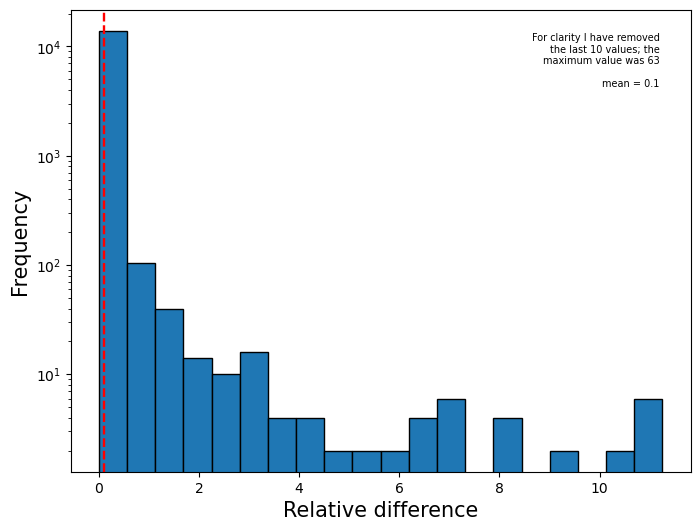

In [25]:
plt.figure(figsize=(8, 6))

average = np.mean(relative_difference)

plt.hist(relative_difference[:-10], bins=20, edgecolor="black")
plt.axvline(average, color="r", linestyle="dashed", linewidth=1.7)

plt.yscale("log")
plt.xlabel("Relative difference", size=15)
plt.ylabel("Frequency", size=15)

plt.text(
    0.95,
    0.95,
    f"For clarity I have removed\nthe last 10 values; the\nmaximum value was {int(max(relative_difference))}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    horizontalalignment="right",
    fontsize=7,
)
plt.text(0.95, 0.85, f"mean = {round(average, 3)}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    horizontalalignment="right",
    fontsize=7,)

plt.savefig(
    f"./results/economic_results/o_info/images/all/gaussian/goodness_null_model_relative_difference_covariance.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

In [30]:
covariance_original = covariance_original.to_numpy()
covariance_gauss = covariance_gauss.to_numpy()

In [31]:
triangular_original = np.triu(covariance_original, k=1).flatten()
triangular_gauss = np.triu(covariance_gauss, k=1).flatten()

In [35]:
correlation_distance = correlation(triangular_original, triangular_gauss)

print("Correlation Distance:", correlation_distance)

Correlation Distance: 4.1397892527772484e-05


<a name="o_info"></a>
## O-information

In [23]:
sectors = [
    "Industrials",
    "Basic Materials",
    "Financials",
    "Consumer Services",
    "Health Care",
    "Utilities",
    "Oil & Gas",
    "Consumer Goods",
]

In [24]:
# I am deleting the data for the Techonolgy sector because there are only a few
financial_ts = financial_ts.drop(columns=["CACI", "CIEN", "DBD", "DDD"])
financial_ts_gauss = financial_ts_gauss.drop(columns=["CACI", "CIEN", "DBD", "DDD"])

In [25]:
binarized_financial_ts = binarized_financial_ts.drop(
    columns=["CACI", "CIEN", "DBD", "DDD"]
)
binarized_financial_ts_gauss = binarized_financial_ts_gauss.drop(
    columns=["CACI", "CIEN", "DBD", "DDD"]
)

<a name="o_info_full_length"></a>
### Full length

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for target in sectors:
    oinfo_one_sector = get_o_infos_same(target, binarized_financial_ts, total=True)
    np.save(
        f"./results/economic_results/o_info/metrics/3/all/one_sector_{target}.npy",
        oinfo_one_sector,
    )

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    for i, sector in enumerate(other_sectors):

        oinfo_two_sectors = get_o_infos_two_different(
            target, sector, binarized_financial_ts, total=True
        )
        np.save(
            f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{target}_two_sector_{sector}.npy",
            oinfo_two_sectors,
        )

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    for sector1 in other_sectors:
        other_sectors2 = [sector for sector in other_sectors if sector != sector1]
        for sector2 in other_sectors2:

            oinfo_three_sectors = get_o_infos_three_different(
                target, sector1, sector2, binarized_financial_ts, total=True
            )
            np.save(
                f"./results/economic_results/o_info/metrics/1_1_1/all/one_sector_{target}_one_sector_{sector1}_one_sector_{sector2}.npy",
                oinfo_three_sectors,
            )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    df_matrix = pd.DataFrame(columns=sectors)
    for target2 in sectors:
        for source in sectors:

            if target2 == target1 and source == target1:
                oinfo_one_sector = np.load(
                    f"./results/economic_results/o_info/metrics/3/all/one_sector_{target2}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_one_sector)

            elif target2 == target1 and source != target1:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{source}_two_sector_{target2}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_two_sectors)

            elif target2 != target1 and source == target1:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{target2}_two_sector_{source}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_two_sectors)

            elif target2 != target1 and source == target2:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{target1}_two_sector_{target2}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_two_sectors)

            elif target2 != target1 and source != target2:
                oinfo_three_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/1_1_1/all/one_sector_{target1}_one_sector_{target2}_one_sector_{source}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_three_sectors)

    df_matrix.to_csv(
        f"./results/economic_results/o_info/dataframes/all/matrix_{target1}.csv",
        index=True,
    )

In [ ]:
for sector in sectors:

    df = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/matrix_{sector}.csv",
        index_col=0,
    )
    sns.heatmap(df, cmap="Blues")

    plt.xlabel("Source", fontsize=13)
    plt.ylabel("Target", fontsize=13)
    plt.title(f"1 in {sector}, 1 in Target, 1 in Source", fontsize=20)

    plt.savefig(
        f"./results/economic_results/o_info/images/all/heatmap_matrix_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

In [ ]:
mini, maxi = 50, -50
for sector in sectors:
    df = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/matrix_{sector}.csv",
        index_col=0,
    )
    if min(df.min()) < mini:
        mini = min(df.min())
    if max(df.max()) > maxi:
        maxi = max(df.max())

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for index, sector in enumerate(sectors):
    row = index // 4
    col = index % 4

    ax = axs[row, col]

    df = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/matrix_{sector}.csv",
        index_col=0,
    )
    sns.heatmap(df, ax=ax, cmap="Blues", vmin=mini, vmax=maxi)

    ax.set_title(f"{sector}", size=19)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.text(0.49, -0.02, "Source", ha="center", va="center", fontsize=24)
fig.text(-0.02, 0.49, "Target", rotation="vertical", va="center", fontsize=24)

plt.tight_layout()

plt.savefig(
    f"./results/economic_results/o_info/images/all/heatmap_matrix_all_sectors.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="o_info_full_length_pdf"></a>
#### Probability density function

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DICTIONARY

diz_pdf = {
    "Industrials": None,
    "Basic Materials": None,
    "Financials": None,
    "Consumer Services": None,
    "Health Care": None,
    "Utilities": None,
    "Oil & Gas": None,
    "Consumer Goods": None,
}

for target in sectors:
    diz_sector = {"3": None, "2_1": None, "1_1_1": None}

    for key in diz_sector.keys():
        if key == "3":
            diz_sector[key] = list(
                np.load(
                    f"./results/economic_results/o_info/metrics/3/all/one_sector_{target}.npy"
                )
            )

        elif key == "2_1":
            a = list()
            other_sectors = [sector for sector in sectors if sector != target]
            for source in other_sectors:
                b = list(
                    np.load(
                        f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{source}_two_sector_{target}.npy"
                    )
                )
                a.append(b)
            diz_sector[key] = [item for sublist in a for item in sublist]

        elif key == "1_1_1":
            a = list()
            other_sectors1 = [sector for sector in sectors if sector != target]
            for source1 in other_sectors1:
                other_sectors2 = [
                    sector for sector in other_sectors1 if sector != source1
                ]
                for source2 in other_sectors2:
                    b = list(
                        np.load(
                            f"./results/economic_results/o_info/metrics/1_1_1/all/one_sector_{target}_one_sector_{source1}_one_sector_{source2}.npy"
                        )
                    )
                    a.append(b)
            diz_sector[key] = [item for sublist in a for item in sublist]

    diz_pdf[target] = diz_sector

with open(
    "./results/economic_results/o_info/dataframes/all/dict_proba_density_function_all.pickle",
    "wb",
) as file:
    pickle.dump(diz_pdf, file)

In [ ]:
with open(
    "./results/economic_results/o_info/dataframes/all/dict_proba_density_function_all.pickle",
    "rb",
) as file:
    diz_pdf = pickle.load(file)

In [ ]:
for sector in sectors:
    keys = list(diz_pdf[sector].keys())
    data = [diz_pdf[sector][key] for key in keys]
    means = [np.mean(data[i]) for i in range(len(data))]

    plt.figure(figsize=(8, 6))
    for i, key in enumerate(keys):
        values_bin, bin_edges = np.histogram(data[i], bins=20)
        if i == 0:
            label = str(f"3 in {sector}")
        elif i == 1:
            label = str(f"2 in {sector}")
        else:
            label = str(f"1 in {sector}")

        plt.bar(
            bin_edges[:-1],
            values_bin / sum(values_bin),
            width=np.diff(bin_edges),
            align="edge",
            alpha=0.6,
            label=label,
        )

    plt.axvline(x=means[0], color="blue", linestyle="--")
    plt.axvline(x=means[1], color="orange", linestyle="--")
    plt.axvline(x=means[2], color="green", linestyle="--")

    plt.xlabel("O-information", size=15)
    plt.ylabel("Probability", size=15)
    plt.tick_params(axis="both", labelsize=12)
    plt.title(f"PDF of {sector}", size=18)
    plt.legend(fontsize="large")

    plt.savefig(
        f"./results/economic_results/o_info/images/all/pdf/PDF_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

for index, sector in enumerate(sectors):
    keys = list(diz_pdf[sector].keys())
    data = [diz_pdf[sector][key] for key in keys]
    means = [np.mean(data[i]) for i in range(len(data))]

    row = index // 4
    col = index % 4

    ax = axs[row, col]

    for i, key in enumerate(keys):
        values_bin, bin_edge = np.histogram(data[i], bins=20)

        if i == 0:
            label = str(f"3 in {sector}")
        elif i == 1:
            label = str(f"2 in {sector}")
        else:
            label = str(f"1 in {sector}")

        ax.bar(
            bin_edge[:-1],
            values_bin / sum(values_bin),
            width=np.diff(bin_edge),
            align="edge",
            alpha=0.6,
            label=label,
        )

    ax.axvline(x=means[0], color="blue", linestyle="--")
    ax.axvline(x=means[1], color="orange", linestyle="--")
    ax.axvline(x=means[2], color="green", linestyle="--")

    ax.set_title(f"PDF of {sector}", size=17)
    ax.legend(fontsize="small")

fig.text(0.5, -0.02, "O-information", ha="center", va="center", fontsize=22)
fig.text(-0.015, 0.5, "Probability", rotation="vertical", va="center", fontsize=22)

plt.tight_layout()

plt.savefig(
    f"./results/economic_results/o_info/images/all/pdf/PDF_all_together.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="o_info_full_length_pdf_friedman"></a>
##### Friedman test

In [31]:
import scikit_posthocs as sp

In [32]:
with open(
    "./results/economic_results/o_info/dataframes/all/dict_proba_density_function_all.pickle",
    "rb",
) as file:
    diz_pdf = pickle.load(file)

In [33]:
def friedman_test(*groups):
    stat, p_value = friedmanchisquare(*groups)
    return stat, p_value

In [34]:
nemenyi_results = {}
friedman_results = []
p_critic = 0.05

for sector in sectors:
    group_3 = diz_pdf[sector]["3"]
    group2 = diz_pdf[sector]["2_1"]
    group3 = diz_pdf[sector]["1_1_1"]
    
    group_2_1 = random.sample(group2, len(group_3))
    group_1_1_1 = random.sample(group3, len(group_3))

    # Perform Friedman test
    stat, p_value = friedman_test(group_3, group_2_1, group_1_1_1)
    friedman_results.append((stat, p_value))

    print(f"Sector: {sector}")
    print(f"Friedman statistic and P-value: {stat}, {p_value}")

    if p_value < p_critic:
        # Perform Nemenyi post hoc test for multiple comparisons
        results = sp.posthoc_nemenyi([group_3, group_2_1, group_1_1_1])
        print("Nemenyi test results:")
        print(results)
        nemenyi_results[sector] = results

    print("\n")

Sector: Industrials
Friedman statistic and P-value: 1132.4280701754396, 1.2484437664265457e-246
Nemenyi test results:
               1              2             3
1   1.000000e+00  1.221596e-101  0.000000e+00
2  1.221596e-101   1.000000e+00  8.265422e-66
3   0.000000e+00   8.265422e-66  1.000000e+00


Sector: Basic Materials
Friedman statistic and P-value: 67.0, 2.8257572871156122e-15
Nemenyi test results:
              1             2             3
1  1.000000e+00  3.142513e-07  1.014066e-18
2  3.142513e-07  1.000000e+00  1.372572e-03
3  1.014066e-18  1.372572e-03  1.000000e+00


Sector: Financials
Friedman statistic and P-value: 600.6963015647198, 3.634590318147444e-131
Nemenyi test results:
               1             2              3
1   1.000000e+00  3.243457e-61  5.592115e-177
2   3.243457e-61  1.000000e+00   5.834873e-31
3  5.592115e-177  5.834873e-31   1.000000e+00


Sector: Consumer Services
Friedman statistic and P-value: 73.38529411764648, 1.160341582079837e-16
Nemenyi tes

In [ ]:
nemenyi_results["Industrials"]

In [ ]:
nemenyi_results["Industrials"][1][2]

In [ ]:
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])

# Aggiunta di un simbolo "*" sopra la linea orizzontale
plt.annotate('*', xy=(2, 5), xytext=(3, 15),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [ ]:
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

for index, sector in enumerate(sectors):
    keys = list(diz_pdf[sector].keys())
    data = [diz_pdf[sector][key] for key in keys]
    means = [np.mean(data[i]) for i in range(len(data))]

    row = index // 4
    col = index % 4

    ax = axs[row, col]

    for i, key in enumerate(keys):
        values_bin, bin_edge = np.histogram(data[i], bins=20)

        if i == 0:
            label = str(f"3 in {sector}")
        elif i == 1:
            label = str(f"2 in {sector}")
        else:
            label = str(f"1 in {sector}")

        ax.bar(
            bin_edge[:-1],
            values_bin / sum(values_bin),
            width=np.diff(bin_edge),
            align="edge",
            alpha=0.6,
            label=label,
        )

    ax.axvline(x=means[0], color="blue", linestyle="--")
    ax.axvline(x=means[1], color="orange", linestyle="--")
    ax.axvline(x=means[2], color="green", linestyle="--")

    ax.set_title(f"PDF of {sector}", size=17)
    ax.legend(fontsize="small")

    # Aggiungi le etichette per i p-value
    ax.annotate(
        f"P-value 3 vs 2_1: {results.iloc[0, 1]:.2f}",
        xy=(0.05, 0.9),
        xycoords="axes fraction",
        fontsize=10,
        color="red" if results.iloc[0, 1] < p_critic else "black",
    )
    ax.annotate(
        f"P-value 3 vs 1_1_1: {results.iloc[0, 2]:.2f}",
        xy=(0.05, 0.8),
        xycoords="axes fraction",
        fontsize=10,
        color="red" if results.iloc[0, 2] < p_critic else "black",
    )
    ax.annotate(
        f"P-value 2_1 vs 1_1_1: {results.iloc[1, 2]:.2f}",
        xy=(0.05, 0.7),
        xycoords="axes fraction",
        fontsize=10,
        color="red" if results.iloc[1, 2] < p_critic else "black",
    )

fig.text(0.5, -0.02, "O-information", ha="center", va="center", fontsize=22)
fig.text(-0.015, 0.5, "Probability", rotation="vertical", va="center", fontsize=22)

# Assicurati che i subplot siano ben allineati
plt.tight_layout()

#plt.savefig(
#    f"./results/economic_results/o_info/images/all/pdf/PDF_all_together.pdf",
#    dpi=600,
#    bbox_inches="tight",
#)

plt.show()

<a name="o_info_full_length_null_model"></a>
#### Null model

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for target in sectors:
    oinfo_one_sector = get_o_infos_same(
        target, binarized_financial_ts_gauss, total=True
    )
    np.save(
        f"./results/economic_results/o_info/metrics/3/all/gaussian/one_sector_{target}.npy",
        oinfo_one_sector,
    )

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    for i, sector in enumerate(other_sectors):

        oinfo_two_sectors = get_o_infos_two_different(
            target, sector, binarized_financial_ts_gauss, total=True
        )
        np.save(
            f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{target}_two_sector_{sector}.npy",
            oinfo_two_sectors,
        )

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    for sector1 in other_sectors:
        other_sectors2 = [sector for sector in other_sectors if sector != sector1]
        for sector2 in other_sectors2:

            oinfo_three_sectors = get_o_infos_three_different(
                target, sector1, sector2, binarized_financial_ts_gauss, total=True
            )
            np.save(
                f"./results/economic_results/o_info/metrics/1_1_1/all/gaussian/one_sector_{target}_one_sector_{sector1}_one_sector_{sector2}.npy",
                oinfo_three_sectors,
            )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    df_matrix = pd.DataFrame(columns=sectors)
    for target2 in sectors:
        for source in sectors:

            if target2 == target1 and source == target1:
                oinfo_one_sector = np.load(
                    f"./results/economic_results/o_info/metrics/3/all/gaussian/one_sector_{target2}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_one_sector)

            elif target2 == target1 and source != target1:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{source}_two_sector_{target2}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_two_sectors)

            elif target2 != target1 and source == target1:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{target2}_two_sector_{source}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_two_sectors)

            elif target2 != target1 and source == target2:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{target1}_two_sector_{target2}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_two_sectors)

            elif target2 != target1 and source != target2:
                oinfo_three_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/1_1_1/all/gaussian/one_sector_{target1}_one_sector_{target2}_one_sector_{source}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_three_sectors)

    df_matrix.to_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/matrix_{target1}.csv",
        index=True,
    )

In [ ]:
for sector in sectors:
    df = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/matrix_{sector}.csv",
        index_col=0,
    )
    sns.heatmap(df, cmap="Blues")

    plt.xlabel("Source", fontsize=13)
    plt.ylabel("Target", fontsize=13)
    plt.title(f"1 in {sector}, 1 in Target, 1 in Source", fontsize=20)

    plt.savefig(
        f"./results/economic_results/o_info/images/all/gaussian/heatmap_matrix_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

In [ ]:
mini, maxi = 50, -50
for sector in sectors:
    df = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/matrix_{sector}.csv",
        index_col=0,
    )
    if min(df.min()) < mini:
        mini = min(df.min())
    if max(df.max()) > maxi:
        maxi = max(df.max())

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for index, sector in enumerate(sectors):
    row = index // 4
    col = index % 4

    ax = axs[row, col]

    df = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/matrix_{sector}.csv",
        index_col=0,
    )
    sns.heatmap(df, ax=ax, cmap="Blues", vmin=mini, vmax=maxi)

    ax.set_title(f"{sector} (null model)", size=19)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.text(0.485, -0.02, "Source", ha="center", va="center", fontsize=24)
fig.text(-0.02, 0.49, "Target", rotation="vertical", va="center", fontsize=24)

plt.tight_layout()

plt.savefig(
    f"./results/economic_results/o_info/images/all/gaussian/heatmap_matrix_all_sectors.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

In [ ]:
mini, maxi = 50, -50
for sector in sectors:
    df_original = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/matrix_{sector}.csv",
        index_col=0,
    )
    if min(df_original.min()) < mini:
        mini = min(df_original.min())
    if max(df_original.max()) > maxi:
        maxi = max(df_original.max())

    df_gauss = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/matrix_{sector}.csv",
        index_col=0,
    )
    if min(df_gauss.min()) < mini:
        mini = min(df_gauss.min())
    if max(df_gauss.max()) > maxi:
        maxi = max(df_gauss.max())

fig, axs = plt.subplots(2, 8, figsize=(40, 10))

for index, sector in enumerate(sectors):
    col = index % 8

    ax = axs[0, col]
    df_original = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/matrix_{sector}.csv",
        index_col=0,
    )
    sns.heatmap(df_original, ax=ax, cmap="Blues", vmin=mini, vmax=maxi)
    ax.set_title(f"{sector} (original)", size=18)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax = axs[1, col]
    df_gauss = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/matrix_{sector}.csv",
        index_col=0,
    )
    sns.heatmap(df_gauss, ax=ax, cmap="Blues", vmin=mini, vmax=maxi)
    ax.set_title(f"{sector} (null model)", size=18)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.text(0.495, -0.02, "Source", ha="center", va="center", fontsize=30)
fig.text(-0.01, 0.485, "Target", rotation="vertical", va="center", fontsize=30)

plt.tight_layout()

plt.savefig(
    f"./results/economic_results/o_info/images/all/gaussian/heatmap_matrix_comparison_original_gaussian_same_scale.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

In [ ]:
mini_gauss, maxi_gauss = 50, -50
mini_original, maxi_original = 50, -50

for sector in sectors:
    df_gauss = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/matrix_{sector}.csv",
        index_col=0,
    )
    if min(df_gauss.min()) < mini_gauss:
        mini_gauss = min(df_gauss.min())
    if max(df_gauss.max()) > maxi_gauss:
        maxi_gauss = max(df_gauss.max())

for sector in sectors:
    df_original = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/matrix_{sector}.csv",
        index_col=0,
    )
    if min(df_original.min()) < mini_original:
        mini_original = min(df_original.min())
    if max(df_original.max()) > maxi_original:
        maxi_original = max(df_original.max())

fig, axs = plt.subplots(2, 8, figsize=(40, 10))

for index, sector in enumerate(sectors):
    col = index % 8

    ax = axs[0, col]
    df_original = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/matrix_{sector}.csv",
        index_col=0,
    )
    sns.heatmap(
        df_original, ax=ax, cmap="Blues", vmin=mini_original, vmax=maxi_original
    )
    ax.set_title(f"{sector} (original)", size=18)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax = axs[1, col]
    df_gauss = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/matrix_{sector}.csv",
        index_col=0,
    )
    sns.heatmap(df_gauss, ax=ax, cmap="Blues", vmin=mini_gauss, vmax=maxi_gauss)
    ax.set_title(f"{sector} (null model)", size=18)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.text(0.495, -0.02, "Source", ha="center", va="center", fontsize=30)
fig.text(-0.01, 0.485, "Target", rotation="vertical", va="center", fontsize=30)

plt.tight_layout()

plt.savefig(
    f"./results/economic_results/o_info/images/all/gaussian/heatmap_matrix_comparison_original_gaussian_different_scale.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="o_info_full_length_null_model_stat"></a>
##### Statistical significance

<a name="o_info_full_length_null_model_stat_t_test"></a>
###### t-test

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    df_matrix_t_value = pd.DataFrame(columns=sectors)
    df_matrix_p_value = pd.DataFrame(columns=sectors)

    for target2 in sectors:
        for source in sectors:

            if target2 == target1 and source == target1:
                oinfo_one_sector_original = np.load(
                    f"./results/economic_results/o_info/metrics/3/all/one_sector_{target2}.npy"
                )
                oinfo_one_sector_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/3/all/gaussian/one_sector_{target2}.npy"
                )
                t, p = t_test(oinfo_one_sector_original, oinfo_one_sector_gauss)
                df_matrix_t_value.at[target2, source] = t
                df_matrix_p_value.at[target2, source] = p

            elif target2 == target1 and source != target1:
                oinfo_two_sectors_original = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{source}_two_sector_{target2}.npy"
                )
                oinfo_two_sectors_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{source}_two_sector_{target2}.npy"
                )
                t, p = t_test(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                df_matrix_t_value.at[target2, source] = t
                df_matrix_p_value.at[target2, source] = p

            elif target2 != target1 and source == target1:
                oinfo_two_sectors_original = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{target2}_two_sector_{source}.npy"
                )
                oinfo_two_sectors_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{target2}_two_sector_{source}.npy"
                )
                t, p = t_test(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                df_matrix_t_value.at[target2, source] = t
                df_matrix_p_value.at[target2, source] = p

            elif target2 != target1 and source == target2:
                oinfo_two_sectors_original = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{target1}_two_sector_{target2}.npy"
                )
                oinfo_two_sectors_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{target1}_two_sector_{target2}.npy"
                )
                t, p = t_test(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                df_matrix_t_value.at[target2, source] = t
                df_matrix_p_value.at[target2, source] = p

            elif target2 != target1 and source != target2:
                oinfo_three_sectors_original = np.load(
                    f"./results/economic_results/o_info/metrics/1_1_1/all/one_sector_{target1}_one_sector_{target2}_one_sector_{source}.npy"
                )
                oinfo_three_sectors_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/1_1_1/all/gaussian/one_sector_{target1}_one_sector_{target2}_one_sector_{source}.npy"
                )
                t, p = t_test(oinfo_three_sectors_original, oinfo_three_sectors_gauss)
                df_matrix_t_value.at[target2, source] = t
                df_matrix_p_value.at[target2, source] = p

    df_matrix_t_value.to_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_t_values_{target1}.csv",
        index=True,
    )
    df_matrix_p_value.to_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_t_p_values_{target1}.csv",
        index=True,
    )

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for index, sector in enumerate(sectors):
    row = index // 4
    col = index % 4

    ax = axs[row, col]

    df_t = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_t_values_{sector}.csv",
        index_col=0,
    )
    df_t = df_t.applymap(sign_t)
    df_p = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_t_p_values_{sector}.csv",
        index_col=0,
    )
    df_p = df_p.applymap(sign_p)
    
    cmap = sns.color_palette(["lightblue"])
    
    force_break_loop = False
    for column in df_p.columns:
        for row in df_p.columns:
            if df_p[column][row] == "red":
                cmap = sns.color_palette(["white", "lightblue"])
                force_break_loop = True
                break
        if force_break_loop:
            break
            
    sns.heatmap(
        df_p.replace({"red": 0, "green": 1}),
        cmap=cmap,
        annot=df_t,
        fmt="s",
        cbar=False,
        ax=ax,
    )

    ax.set_title(f"{sector} (t-test)", size=19)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.text(0.5, -0.02, "Source", ha="center", va="center", fontsize=25)
fig.text(-0.02, 0.5, "Target", rotation="vertical", va="center", fontsize=25)

plt.tight_layout()

plt.savefig(
    f"./results/economic_results/o_info/images/all/gaussian/statistical_significance/heatmap_matrix_t_test_all_sectors.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="o_info_full_length_null_model_stat_Z_score"></a>
###### Z-score

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    df_matrix_z_score = pd.DataFrame(columns=sectors)
    df_matrix_p_value = pd.DataFrame(columns=sectors)
    for target2 in sectors:
        for source in sectors:

            if target2 == target1 and source == target1:
                oinfo_one_sector_original = np.load(
                    f"./results/economic_results/o_info/metrics/3/all/one_sector_{target2}.npy"
                )
                oinfo_one_sector_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/3/all/gaussian/one_sector_{target2}.npy"
                )
                z, p = z_score(oinfo_one_sector_original, oinfo_one_sector_gauss)
                df_matrix_z_score.at[target2, source] = z
                df_matrix_p_value.at[target2, source] = p

            elif target2 == target1 and source != target1:
                oinfo_two_sectors_original = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{source}_two_sector_{target2}.npy"
                )
                oinfo_two_sectors_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{source}_two_sector_{target2}.npy"
                )
                z, p = z_score(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                df_matrix_z_score.at[target2, source] = z
                df_matrix_p_value.at[target2, source] = p

            elif target2 != target1 and source == target1:
                oinfo_two_sectors_original = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{target2}_two_sector_{source}.npy"
                )
                oinfo_two_sectors_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{target2}_two_sector_{source}.npy"
                )
                z, p = z_score(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                df_matrix_z_score.at[target2, source] = z
                df_matrix_p_value.at[target2, source] = p

            elif target2 != target1 and source == target2:
                oinfo_two_sectors_original = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/one_sector_{target1}_two_sector_{target2}.npy"
                )
                oinfo_two_sectors_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/one_sector_{target1}_two_sector_{target2}.npy"
                )
                z, p = z_score(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                df_matrix_z_score.at[target2, source] = z
                df_matrix_p_value.at[target2, source] = p

            elif target2 != target1 and source != target2:
                oinfo_three_sectors_original = np.load(
                    f"./results/economic_results/o_info/metrics/1_1_1/all/one_sector_{target1}_one_sector_{target2}_one_sector_{source}.npy"
                )
                oinfo_three_sectors_gauss = np.load(
                    f"./results/economic_results/o_info/metrics/1_1_1/all/gaussian/one_sector_{target1}_one_sector_{target2}_one_sector_{source}.npy"
                )
                z, p = z_score(oinfo_three_sectors_original, oinfo_three_sectors_gauss)
                df_matrix_z_score.at[target2, source] = z
                df_matrix_p_value.at[target2, source] = p

    df_matrix_z_score.to_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_Z_score_{target1}.csv",
        index=True,
    )
    df_matrix_p_value.to_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_Z_p_value_{target1}.csv",
        index=True,
    )

In [ ]:
mini, maxi = 50, -50
for sector in sectors:
    df = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_Z_score_{sector}.csv",
        index_col=0,
    )
    if min(df.min()) < mini:
        mini = min(df.min())
    if max(df.max()) > maxi:
        maxi = max(df.max())

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for index, sector in enumerate(sectors):
    row = index // 4
    col = index % 4

    ax = axs[row, col]

    df_z = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_Z_score_{sector}.csv",
        index_col=0,
    )

    sns.heatmap(df_z, cmap="coolwarm", ax=ax, vmin=mini, vmax=maxi)

    ax.set_title(f"{sector} (Z-score)", size=19)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.text(0.483, -0.02, "Source", ha="center", va="center", fontsize=25)
fig.text(-0.02, 0.49, "Target", rotation="vertical", va="center", fontsize=25)

plt.tight_layout()

plt.savefig(
    f"./results/economic_results/o_info/images/all/gaussian/statistical_significance/heatmap_matrix_Z_score_all_sectors.pdf",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

<a name="o_info_full_length_null_model_stat_comparison"></a>
###### Comparison

In [ ]:
for sector in sectors:
    plt.figure(figsize=(6, 4))
    
    df_z = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_Z_score_{sector}.csv",
        index_col=0,
    )
    df_t = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_t_values_{sector}.csv",
        index_col=0,
    )
    
    for target in sectors:
        plt.scatter(df_z[target], df_t[target], c="blue")

    plt.title(f"Z-score - t-test for {sector}")
    plt.xlabel("Z-score")
    plt.ylabel("t-test")

    plt.savefig(
        f"./results/economic_results/o_info/images/all/gaussian/statistical_significance/scatterplot_Z_score_t_test_sector_{sector}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

In [ ]:
plt.figure(figsize=(6, 4))

for sector in sectors:

    df_z = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_Z_score_{sector}.csv",
        index_col=0,
    )
    df_t = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_t_values_{sector}.csv",
        index_col=0,
    )

    for target in sectors:
        plt.scatter(df_z[target], df_t[target], c="blue")

plt.title(f"Scatterplot Z-score - t-test")
plt.xlabel("Z-score")
plt.ylabel("t-test")

plt.savefig(
   f"./results/economic_results/o_info/images/all/gaussian/statistical_significance/scatterplot_Z_score_t_test_one_plot.pdf",
   dpi=600,
   bbox_inches="tight",
)

plt.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, sector in enumerate(sectors):
    df_z = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_Z_score_{sector}.csv",
        index_col=0,
    )
    df_t = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_t_values_{sector}.csv",
        index_col=0,
    )

    row = i // 4
    col = i % 4

    for target in sectors:
        axs[row, col].scatter(df_z[target], df_t[target], c="blue")
    axs[row, col].set_title(f"Z-score - t-test for {sector}", size=17)
    axs[row, col].set_xlabel("Z-score", size=14)
    axs[row, col].set_ylabel("t-test", size=14)

plt.tight_layout()
plt.savefig(
    f"./results/economic_results/o_info/images/all/gaussian/statistical_significance/scatterplot_Z_score_t_test_subplots.pdf",
    dpi=600,
    bbox_inches="tight",
)
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, sector in enumerate(sectors):
    df_z = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_Z_p_value_{sector}.csv",
        index_col=0,
    )
    df_t = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/statistical_significance/matrix_t_p_values_{sector}.csv",
        index_col=0,
    )

    row = i // 4
    col = i % 4

    for target in sectors:
        axs[row, col].scatter(df_z[target], df_t[target], c="blue")
    axs[row, col].axhline(y=0.05, color="r", linestyle="--")

    axs[row, col].set_title(f"p-values Z-score - t-test for {sector}", size=16)
    axs[row, col].set_xlabel("p-value Z-score", size=14)
    axs[row, col].set_ylabel("p-value t-test", size=14)

plt.tight_layout()
plt.savefig(
   f"./results/economic_results/o_info/images/all/gaussian/statistical_significance/scatterplot_p_values_Z_score_t_test_subplots.pdf",
   dpi=600,
   bbox_inches="tight",
)
plt.show()

<a name="o_info_full_length_null_model_no_multivariate"></a>
#### Null model no multivariate

## PER ORA È SBAGLIATO

In [ ]:
mean_values = financial_ts.iloc[:, 1:].mean()
variance_values = financial_ts.iloc[:, 1:].var()

generated_data_list = []

for column in financial_ts.columns[1:]:
    mean = mean_values[column]
    variance = variance_values[column]

    generated_data = np.random.normal(mean, np.sqrt(variance), financial_ts.shape[0])
    generated_data_list.append(pd.Series(generated_data, name=column))

financial_ts_gauss_no_multivariate = pd.concat(
    [financial_ts["Date"]] + generated_data_list, axis=1
)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for target in sectors:
    oinfo_one_sector = get_o_infos_same(
        target, financial_ts_gauss_no_multivariate, total=True
    )
    np.save(
        f"./results/economic_results/o_info/metrics/3/all/gaussian/no_multivariate/one_{target}.npy",
        oinfo_one_sector,
    )

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    for i, sector in enumerate(other_sectors):
        oinfo_two_sectors = get_o_infos_two_different(
            target, sector, financial_ts_gauss_no_multivariate, total=True
        )
        np.save(
            f"./results/economic_results/o_info/metrics/2_1/all/gaussian/no_multivariate/one_{target}_two_{sector}.npy",
            oinfo_two_sectors,
        )

for target in sectors:
    other_sectors = [sector for sector in sectors if sector != target]
    for sector1 in other_sectors:
        other_sectors2 = [sector for sector in other_sectors if sector != sector1]
        for sector2 in other_sectors2:
            oinfo_three_sectors = get_o_infos_three_different(
                target, sector1, sector2, financial_ts_gauss_no_multivariate, total=True
            )
            np.save(
                f"./results/economic_results/o_info/metrics/1_1_1/all/gaussian/no_multivariate/one_{target}_one_{sector1}_one_{sector2}.npy",
                oinfo_three_sectors,
            )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    df_matrix = pd.DataFrame(columns=sectors)
    for target2 in sectors:
        for source in sectors:

            if target2 == target1 and source == target1:
                oinfo_one_sector = np.load(
                    f"./results/economic_results/o_info/metrics/3/all/gaussian/no_multivariate/one_{target2}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_one_sector)

            elif target2 == target1 and source != target1:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/no_multivariate/one_{source}_two_{target2}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_two_sectors)

            elif target2 != target1 and source == target1:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/no_multivariate/one_{target2}_two_{source}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_two_sectors)

            elif target2 != target1 and source == target2:
                oinfo_two_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/all/gaussian/no_multivariate/one_{target1}_two_{target2}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_two_sectors)

            elif target2 != target1 and source != target2:
                oinfo_three_sectors = np.load(
                    f"./results/economic_results/o_info/metrics/1_1_1/all/gaussian/no_multivariate/one_{target1}_one_{target2}_one_{source}.npy"
                )
                df_matrix.at[target2, source] = np.mean(oinfo_three_sectors)

    df_matrix.to_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/no_multivariate/matrix_{target1}.csv",
        index=True,
    )

In [ ]:
sector = "Industrials"
df_matrix = pd.read_csv(
    f"./results/economic_results/o_info/dataframes/all/gaussian/no_multivariate/matrix_{sector}.csv",
    index_col=0,
)
df_matrix

In [ ]:
mini, maxi = 50, -50
for sector in sectors:
    df = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/no_multivariate/matrix_{sector}.csv",
        index_col=0,
    )
    if min(df.min()) < mini:
        mini = min(df.min())
    if max(df.max()) > maxi:
        maxi = max(df.max())

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for index, sector in enumerate(sectors):
    row = index // 4
    col = index % 4

    ax = axs[row, col]

    df = pd.read_csv(
        f"./results/economic_results/o_info/dataframes/all/gaussian/no_multivariate/matrix_{sector}.csv",
        index_col=0,
    )
    sns.heatmap(df, ax=ax, cmap="Blues", vmin=mini, vmax=maxi)

    ax.set_title(f"{sector} (no multivariate)", size=19)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.text(0.485, -0.02, "Source", ha="center", va="center", fontsize=24)
fig.text(-0.02, 0.49, "Target", rotation="vertical", va="center", fontsize=24)

plt.tight_layout()

#plt.savefig(
#    f"./results/economic_results/o_info/images/all/gaussian/no_multivariate/heatmap_matrix_all_sectors.pdf",
#    dpi=600,
#    bbox_inches="tight",
#)

plt.show()

<a name="o_info_divided_year"></a>
### Divided by year

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])
years = financial_ts["Date"].dt.year.unique()[1:]

diz_one_year = {}

for year in years:
    df_year = financial_ts[financial_ts["Date"].dt.year == year]
    diz_one_year[year] = df_year

In [ ]:
tw = 7
diz_one_year_bin = {}

for year in years:
    diz_one_year_bin[year] = binarize_df(diz_one_year[year], tw)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for year in years:
    for target in sectors:
        oinfo_one_sector = get_o_infos_same(target, diz_one_year_bin[year], total=True)
        np.save(
            f"./results/economic_results/o_info/metrics/3/divided_years/one_sector_{target}_year_{year}.npy",
            oinfo_one_sector,
        )

for year in years:
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            oinfo_two_sectors = get_o_infos_two_different(
                target, sector, diz_one_year_bin[year], total=True
            )
            np.save(
                f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target}_two_sector_{sector}_year_{year}.npy",
                oinfo_two_sectors,
            )

for year in years:
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for sector1 in other_sectors:
            other_sectors2 = [sector for sector in other_sectors if sector != sector1]
            for sector2 in other_sectors2:

                oinfo_three_sectors = get_o_infos_three_different(
                    target, sector1, sector2, diz_one_year_bin[year], total=True
                )
                np.save(
                    f"./results/economic_results/o_info/metrics/1_1_1/divided_years/one_sector_{target}_one_sector_{sector1}_one_sector_{sector2}_year_{year}.npy",
                    oinfo_three_sectors,
                )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    for target2 in sectors:
        df_one_year = pd.DataFrame(columns=years)
        for year in years:
            for source in sectors:

                if target2 == target1 and source == target1:
                    oinfo_one_sector = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/one_sector_{target2}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_one_sector)

                elif target2 == target1 and source != target1:
                    oinfo_two_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_two_sectors)

                elif target2 != target1 and source == target1:
                    oinfo_two_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_two_sectors)

                elif target2 != target1 and source == target2:
                    oinfo_two_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_two_sectors)

                elif target2 != target1 and source != target2:
                    oinfo_three_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/one_sector_{target1}_one_sector_{target2}_one_sector_{source}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_three_sectors)

        df_one_year.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/dataframe_{target1}_{target2}.csv",
            index=True,
        )

In [ ]:
for target1 in sectors:
    for target2 in sectors:

        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )

        sns.heatmap(df, cmap="Blues")

        plt.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        plt.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        plt.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        plt.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        plt.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        plt.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        plt.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        plt.xlabel("Year", fontsize=15)
        plt.ylabel("Source", fontsize=15)
        plt.title(f"1 {target1}, 1 {target2}", fontsize=18)

        # plt.legend()

        plt.savefig(
            f"./results/economic_results/o_info/images/divided_years/heatmap_{target1}_{target2}.pdf",
            dpi=600,
            bbox_inches="tight",
        )

        plt.show()

In [ ]:
mini = [50 for i in range(len(sectors))]
maxi = [-50 for i in range(len(sectors))]

for i, target1 in enumerate(sectors):
    for target2 in sectors:
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )
        if min(df.min()) < mini[i]:
            mini[i] = min(df.min())
        if max(df.max()) > maxi[i]:
            maxi[i] = max(df.max())

for index1, sector1 in enumerate(sectors):
    fig, axs = plt.subplots(2, 4, figsize=(21, 12))

    for index2, sector2 in enumerate(sectors):
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/dataframe_{sector1}_{sector2}.csv",
            index_col=0,
        )

        row = index2 // 4
        col = index2 % 4

        ax = axs[row, col]

        sns.heatmap(df, ax=ax, cmap="Blues", vmin=mini[index1], vmax=maxi[index1])

        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2}", size=25)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

    fig.text(0.485, -0.03, "Year", ha="center", va="center", fontsize=28)
    fig.text(-0.02, 0.48, "Sector", rotation="vertical", va="center", fontsize=28)

    plt.suptitle(f"{sector1}", size=40, x=0.485)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/heatmap_grouped_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="o_info_one_year_null_model"></a>
#### Null model

<a name="o_info_one_year_null_model_randomised_divided"></a>
##### Randomised and divided by year

In [ ]:
financial_ts_gauss["Date"] = pd.to_datetime(financial_ts_gauss["Date"])
years = financial_ts_gauss["Date"].dt.year.unique()[1:]

diz_one_year = {}

for year in years:
    df_year = financial_ts_gauss[financial_ts_gauss["Date"].dt.year == year]
    diz_one_year[year] = df_year

In [ ]:
tw = 7
diz_one_year_gaussian_bin = {}

for year in years:
    diz_one_year_gaussian_bin[year] = binarize_df(diz_one_year[year], tw)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for year in years:
    for target in sectors:
        oinfo_one_sector = get_o_infos_same(
            target, diz_one_year_gaussian_bin[year], total=True
        )
        np.save(
            f"./results/economic_results/o_info/metrics/3/divided_years/gaussian_before/one_sector_{target}_year_{year}.npy",
            oinfo_one_sector,
        )

for year in years:
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            oinfo_two_sectors = get_o_infos_two_different(
                target, sector, diz_one_year_gaussian_bin[year], total=True
            )
            np.save(
                f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{target}_two_sector_{sector}_year_{year}.npy",
                oinfo_two_sectors,
            )

for year in years:
    for target in sectors:
        other_sectors1 = [sector for sector in sectors if sector != target]
        for sector1 in other_sectors1:
            other_sectors2 = [sector for sector in other_sectors1 if sector != sector1]
            for sector2 in other_sectors2:

                oinfo_three_sectors = get_o_infos_three_different(
                    target,
                    sector1,
                    sector2,
                    diz_one_year_gaussian_bin[year],
                    total=True,
                )
                np.save(
                    f"./results/economic_results/o_info/metrics/1_1_1/divided_years/gaussian_before/one_{target}_one_{sector1}_one_{sector2}_year_{year}.npy",
                    oinfo_three_sectors,
                )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    for target2 in sectors:
        df_one_year = pd.DataFrame(columns=years)
        for year in years:
            for source in sectors:

                if target2 == target1 and source == target1:
                    oinfo_one_sector = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/gaussian_before/one_sector_{target2}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_one_sector)

                elif target2 == target1 and source != target1:
                    oinfo_two_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_two_sectors)

                elif target2 != target1 and source == target1:
                    oinfo_two_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_two_sectors)

                elif target2 != target1 and source == target2:
                    oinfo_two_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_two_sectors)

                elif target2 != target1 and source != target2:
                    oinfo_three_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/gaussian_before/one_{target1}_one_{target2}_one_{source}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_three_sectors)

        df_one_year.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/dataframe_{target1}_{target2}.csv",
            index=True,
        )

In [ ]:
for target1 in sectors:
    for target2 in sectors:

        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )

        sns.heatmap(df, cmap="Blues")

        plt.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        plt.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        plt.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        plt.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        plt.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        plt.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        plt.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        plt.xlabel("Year", fontsize=15)
        plt.ylabel("Source", fontsize=15)
        plt.title(f"Before split: 1 {target1}, 1 {target2}", fontsize=18)

        # plt.legend()

        plt.savefig(
            f"./results/economic_results/o_info/images/divided_years/gaussian_before/heatmap_{target1}_{target2}.pdf",
            dpi=600,
            bbox_inches="tight",
        )

        plt.show()

In [ ]:
mini = [50 for i in range(len(sectors))]
maxi = [-50 for i in range(len(sectors))]

for i, target1 in enumerate(sectors):
    for target2 in sectors:
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )
        if min(df.min()) < mini[i]:
            mini[i] = min(df.min())
        if max(df.max()) > maxi[i]:
            maxi[i] = max(df.max())

for index1, sector1 in enumerate(sectors):
    fig, axs = plt.subplots(2, 4, figsize=(21, 12))

    for index2, sector2 in enumerate(sectors):
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/dataframe_{sector1}_{sector2}.csv",
            index_col=0,
        )

        row = index2 // 4
        col = index2 % 4

        ax = axs[row, col]

        sns.heatmap(df, ax=ax, cmap="Blues", vmin=mini[index1], vmax=maxi[index1])

        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2}", size=25)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

    fig.text(0.485, -0.03, "Year", ha="center", va="center", fontsize=28)
    fig.text(-0.02, 0.48, "Sector", rotation="vertical", va="center", fontsize=28)

    plt.suptitle(f"Before split: {sector1}", size=40, x=0.485)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_before/heatmap_grouped_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

In [ ]:
mini_gauss = [50 for i in range(len(sectors))]
maxi_gauss = [-50 for i in range(len(sectors))]

for i, target1 in enumerate(sectors):
    for target2 in sectors:
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )
        if min(df.min()) < mini_gauss[i]:
            mini_gauss[i] = min(df.min())
        if max(df.max()) > maxi_gauss[i]:
            maxi_gauss[i] = max(df.max())

mini_original = [50 for i in range(len(sectors))]
maxi_original = [-50 for i in range(len(sectors))]

for i, target1 in enumerate(sectors):
    for target2 in sectors:
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )
        if min(df.min()) < mini_original[i]:
            mini_original[i] = min(df.min())
        if max(df.max()) > maxi_original[i]:
            maxi_original[i] = max(df.max())


for index1, sector1 in enumerate(sectors):
    fig, axs = plt.subplots(2, 8, figsize=(40, 12))

    for index2, sector2 in enumerate(sectors):
        col = index2 % 8

        ax = axs[0, col]
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/dataframe_{sector1}_{sector2}.csv",
            index_col=0,
        )
        sns.heatmap(
            df,
            ax=ax,
            cmap="Blues",
            vmin=mini_original[index1],
            vmax=maxi_original[index1],
        )
        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2} (original)", size=22)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

        ax = axs[1, col]
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/dataframe_{sector1}_{sector2}.csv",
            index_col=0,
        )
        sns.heatmap(
            df, ax=ax, cmap="Blues", vmin=mini_gauss[index1], vmax=maxi_gauss[index1]
        )

        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2} (null)", size=22)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

    fig.text(0.49, -0.03, "Year", ha="center", va="center", fontsize=30)
    fig.text(-0.015, 0.465, "Sector", rotation="vertical", va="center", fontsize=30)

    plt.suptitle(f"Comparison before split: {sector1}", size=40, x=0.49)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_before/heatmap_grouped_comparison_original_gaussian_before_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="o_info_one_year_null_model_randomised_divided_stat"></a>
###### Statistical significance

<a name="o_info_one_year_null_model_randomised_divided_stat_t_test"></a>
###### t-test

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])
years = financial_ts["Date"].dt.year.unique()[1:]

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    for target2 in sectors:
        df_one_year_t_value = pd.DataFrame(columns=years)
        df_one_year_p_value = pd.DataFrame(columns=years)
        for year in years:
            for source in sectors:

                if target2 == target1 and source == target1:
                    oinfo_one_sector_original = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/one_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_one_sector_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/gaussian_before/one_sector_{target2}_year_{year}.npy"
                    )
                    t, p = t_test(oinfo_one_sector_original, oinfo_one_sector_gauss)
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

                elif target2 == target1 and source != target1:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    t, p = t_test(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source == target1:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    t, p = t_test(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source == target2:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    t, p = t_test(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source != target2:
                    oinfo_three_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/one_sector_{target1}_one_sector_{target2}_one_sector_{source}_year_{year}.npy"
                    )
                    oinfo_three_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/gaussian_before/one_{target1}_one_{target2}_one_{source}_year_{year}.npy"
                    )
                    t, p = t_test(
                        oinfo_three_sectors_original, oinfo_three_sectors_gauss
                    )
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

        df_one_year_t_value.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_t_values_{target1}_{target2}.csv",
            index=True,
        )
        df_one_year_p_value.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_t_p_values_{target1}_{target2}.csv",
            index=True,
        )

In [ ]:
for index1, sector1 in enumerate(sectors):
    fig, axs = plt.subplots(2, 4, figsize=(21, 12))

    for index2, sector2 in enumerate(sectors):
        row = index2 // 4
        col = index2 % 4
        ax = axs[row, col]
        
        df_t = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_t_values_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_t = df_t.applymap(sign_t)
        df_p = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_t_p_values_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_p = df_p.applymap(sign_p)
    
        cmap = sns.color_palette(["lightblue"])

        force_break_loop = False
        for column in df_p.columns:
            for index, row in df_p.iterrows():
                if row[column] == "red":
                    cmap = sns.color_palette(["white", "lightblue"])
                    force_break_loop = True
                    break
            if force_break_loop:
                break
                
        sns.heatmap(
            df_p.replace({"red": 0, "green": 1}),
            cmap=cmap,
            annot=df_t,
            fmt="s",
            cbar=False,
            ax=ax,
        )

        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2} (t-test)", size=22)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

    fig.text(0.50, -0.03, "Year", ha="center", va="center", fontsize=25)
    fig.text(-0.02, 0.472, "Sector", rotation="vertical", va="center", fontsize=25)

    plt.suptitle(f"Before split: {sector1}", size=40, x=0.50)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_before/statistical_significance/heatmap_grouped_before_stat_sign_t_test_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="o_info_one_year_null_model_randomised_divided_stat_Z_score"></a>
###### Z-score

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])
years = financial_ts["Date"].dt.year.unique()[1:]

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    for target2 in sectors:
        df_one_year_z_score = pd.DataFrame(columns=years)
        df_one_year_p_value = pd.DataFrame(columns=years)
        for year in years:
            for source in sectors:

                if target2 == target1 and source == target1:
                    oinfo_one_sector_original = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/one_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_one_sector_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/gaussian_before/one_sector_{target2}_year_{year}.npy"
                    )
                    z, p = z_score(oinfo_one_sector_original, oinfo_one_sector_gauss)
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

                elif target2 == target1 and source != target1:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    z, p = z_score(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source == target1:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    z, p = z_score(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source == target2:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_before/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    z, p = z_score(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source != target2:
                    oinfo_three_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/one_sector_{target1}_one_sector_{target2}_one_sector_{source}_year_{year}.npy"
                    )
                    oinfo_three_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/gaussian_before/one_{target1}_one_{target2}_one_{source}_year_{year}.npy"
                    )
                    z, p = z_score(
                        oinfo_three_sectors_original, oinfo_three_sectors_gauss
                    )
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

        df_one_year_z_score.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_z_score_{target1}_{target2}.csv",
            index=True,
        )
        df_one_year_p_value.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_z_p_value_{target1}_{target2}.csv",
            index=True,
        )

In [ ]:
mini = [50 for i in range(len(sectors))]
maxi = [-50 for i in range(len(sectors))]

for i, target1 in enumerate(sectors):
    for target2 in sectors:
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_z_score_{target1}_{target2}.csv",
            index_col=0,
        )
        if min(df.min()) < mini[i]:
            mini[i] = min(df.min())
        if max(df.max()) > maxi[i]:
            maxi[i] = max(df.max())

for index1, sector1 in enumerate(sectors):
    fig, axs = plt.subplots(2, 4, figsize=(21, 12))

    for index2, sector2 in enumerate(sectors):
        df_z = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_z_score_{sector1}_{sector2}.csv",
            index_col=0,
        )

        row = index2 // 4
        col = index2 % 4

        ax = axs[row, col]

        sns.heatmap(
            df_z, ax=ax, cmap="coolwarm", vmin=mini[index1], vmax=maxi[index1]
        )

        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2} (Z-score)", size=22)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

    fig.text(0.485, -0.03, "Year", ha="center", va="center", fontsize=25)
    fig.text(-0.02, 0.478, "Sector", rotation="vertical", va="center", fontsize=25)

    plt.suptitle(f"Before split: {sector1}", size=40, x=0.485)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_before/statistical_significance/heatmap_grouped_before_stat_sign_Z_score_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="o_info_one_year_null_model_randomised_divided_stat_comparison"></a>
###### Comparison

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])
years = financial_ts["Date"].dt.year.unique()[1:]

In [ ]:
for sector1 in sectors:
    for sector2 in sectors:
        plt.figure(figsize=(6, 4))

        df_z = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_z_score_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_t = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_t_values_{sector1}_{sector2}.csv",
            index_col=0,
        )

        color_map = plt.colormaps["viridis"]
        color_list = color_map(np.linspace(0, 1, len(df_z)))
        
        for year in years:
            plt.scatter(df_z[str(year)], df_t[str(year)], c=color_list)

        plt.title(f"Z-score - t-test {sector1} {sector2}")
        plt.xlabel("Z-score")
        plt.ylabel("t-test")

        plt.savefig(
            f"./results/economic_results/o_info/images/divided_years/gaussian_before/statistical_significance/scatterplot_Z_score_t_test_sector_{sector1}_{sector2}.pdf",
            dpi=600,
            bbox_inches="tight",
        )

        plt.show()

In [ ]:
for sector1 in sectors:
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, sector2 in enumerate(sectors):
        df_z = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_z_score_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_t = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_t_values_{sector1}_{sector2}.csv",
            index_col=0,
        )

        row = i // 4
        col = i % 4

        color_map = plt.colormaps["viridis"]
        color_list = color_map(np.linspace(0, 1, len(df_z)))

        for year in years:
            axs[row, col].scatter(df_z[str(year)], df_t[str(year)], c=color_list)

        axs[row, col].set_title(f"{sector2}", size=17)
        axs[row, col].set_xlabel("Z-score", size=14)
        axs[row, col].set_ylabel("t-test", size=14)

    fig.suptitle(f"{sector1}", fontsize=30, y=1.01)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_before/statistical_significance/scatterplot_Z_score_t_test_sector_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )
    plt.show()

In [ ]:
for sector1 in sectors:
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, sector2 in enumerate(sectors):
        df_z = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_z_p_value_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_t = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_before/statistical_significance/dataframe_t_p_values_{sector1}_{sector2}.csv",
            index_col=0,
        )

        row = i // 4
        col = i % 4

        for year in years:
            axs[row, col].scatter(df_z[str(year)], df_t[str(year)], c="blue")
        axs[row, col].axhline(y=0.05, color="r", linestyle="--")

        axs[row, col].set_title(f"{sector2}", size=17)
        axs[row, col].set_xlabel("p-value Z-score", size=14)
        axs[row, col].set_ylabel("p-value t-test", size=14)

    fig.suptitle(f"{sector1}", fontsize=30, y=1.01)
    plt.tight_layout()
    
    plt.savefig(
       f"./results/economic_results/o_info/images/divided_years/gaussian_before/statistical_significance/scatterplot_p_values_Z_score_t_test_sector_{sector1}.pdf",
       dpi=600,
       bbox_inches="tight",
    )
    plt.show()

<a name="o_info_one_year_null_model_divided_randomised"></a>
##### Divided by year and randomised

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])
years = financial_ts["Date"].dt.year.unique()[1:]

diz_one_year = {}

for year in years:
    df_year = financial_ts[financial_ts["Date"].dt.year == year].copy()
    df_year["Date"] = pd.to_datetime(df_year["Date"])
    diz_one_year[year] = df_year

In [ ]:
diz_one_year_gauss = {}

for year in years:
    average_columns = diz_one_year[year].iloc[:, 1:].mean()
    covariance = diz_one_year[year].iloc[:, 1:].cov()
    num_samples = len(diz_one_year[year])

    generated_values = np.random.multivariate_normal(
        average_columns, covariance, num_samples
    )
    df_gauss = pd.DataFrame(
        generated_values, columns=diz_one_year[year].iloc[:, 1:].columns
    )

    first_column = diz_one_year[year].iloc[:, 0]
    df_gauss.insert(0, "Date", first_column)

    diz_one_year_gauss[year] = df_gauss

In [ ]:
tw = 7
diz_one_year_gaussian_bin = {}

for year in years:
    diz_one_year_gaussian_bin[year] = binarize_df(diz_one_year_gauss[year], tw)

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATA

for year in years:
    for target in sectors:
        oinfo_one_sector = get_o_infos_same(
            target, diz_one_year_gaussian_bin[year], total=True
        )
        np.save(
            f"./results/economic_results/o_info/metrics/3/divided_years/gaussian_after/one_sector_{target}_year_{year}.npy",
            oinfo_one_sector,
        )

for year in years:
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for i, sector in enumerate(other_sectors):

            oinfo_two_sectors = get_o_infos_two_different(
                target, sector, diz_one_year_gaussian_bin[year], total=True
            )
            np.save(
                f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{target}_two_sector_{sector}_year_{year}.npy",
                oinfo_two_sectors,
            )

for year in years:
    for target in sectors:
        other_sectors = [sector for sector in sectors if sector != target]
        for sector1 in other_sectors:
            other_sectors2 = [sector for sector in other_sectors if sector != sector1]
            for sector2 in other_sectors2:

                oinfo_three_sectors = get_o_infos_three_different(
                    target,
                    sector1,
                    sector2,
                    diz_one_year_gaussian_bin[year],
                    total=True,
                )
                np.save(
                    f"./results/economic_results/o_info/metrics/1_1_1/divided_years/gaussian_after/one_{target}_one_{sector1}_one_{sector2}_year_{year}.npy",
                    oinfo_three_sectors,
                )

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    for target2 in sectors:
        df_one_year = pd.DataFrame(columns=years)
        for year in years:
            for source in sectors:

                if target2 == target1 and source == target1:
                    oinfo_one_sector = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/gaussian_after/one_sector_{target2}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_one_sector)

                elif target2 == target1 and source != target1:
                    oinfo_two_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_two_sectors)

                elif target2 != target1 and source == target1:
                    oinfo_two_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_two_sectors)

                elif target2 != target1 and source == target2:
                    oinfo_two_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_two_sectors)

                elif target2 != target1 and source != target2:
                    oinfo_three_sectors = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/gaussian_after/one_{target1}_one_{target2}_one_{source}_year_{year}.npy"
                    )
                    df_one_year.at[source, year] = np.mean(oinfo_three_sectors)

        df_one_year.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/dataframe_{target1}_{target2}.csv",
            index=True,
        )

In [ ]:
for target1 in sectors:
    for target2 in sectors:

        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )

        sns.heatmap(df, cmap="Blues")

        plt.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        plt.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        plt.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        plt.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        plt.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        plt.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        plt.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        plt.xlabel("Year", fontsize=15)
        plt.ylabel("Source", fontsize=15)
        plt.title(f"After split: 1 {target1}, 1 {target2}", fontsize=18)

        # plt.legend()

        plt.savefig(
            f"./results/economic_results/o_info/images/divided_years/gaussian_after/heatmap_{target1}_{target2}.pdf",
            dpi=600,
            bbox_inches="tight",
        )

        plt.show()

In [ ]:
mini = [50 for i in range(len(sectors))]
maxi = [-50 for i in range(len(sectors))]

for i, target1 in enumerate(sectors):
    for target2 in sectors:
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )
        if min(df.min()) < mini[i]:
            mini[i] = min(df.min())
        if max(df.max()) > maxi[i]:
            maxi[i] = max(df.max())

for index1, sector1 in enumerate(sectors):
    fig, axs = plt.subplots(2, 4, figsize=(21, 12))

    for index2, sector2 in enumerate(sectors):
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/dataframe_{sector1}_{sector2}.csv",
            index_col=0,
        )

        row = index2 // 4
        col = index2 % 4

        ax = axs[row, col]

        sns.heatmap(df, ax=ax, cmap="Blues", vmin=mini[index1], vmax=maxi[index1])

        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2}", size=25)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

    fig.text(0.485, -0.03, "Year", ha="center", va="center", fontsize=28)
    fig.text(-0.02, 0.48, "Sector", rotation="vertical", va="center", fontsize=28)

    plt.suptitle(f"After split: {sector1}", size=40, x=0.485)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_after/heatmap_grouped_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

In [ ]:
mini_gauss = [50 for i in range(len(sectors))]
maxi_gauss = [-50 for i in range(len(sectors))]

for i, target1 in enumerate(sectors):
    for target2 in sectors:
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )
        if min(df.min()) < mini_gauss[i]:
            mini_gauss[i] = min(df.min())
        if max(df.max()) > maxi_gauss[i]:
            maxi_gauss[i] = max(df.max())

mini_original = [50 for i in range(len(sectors))]
maxi_original = [-50 for i in range(len(sectors))]

for i, target1 in enumerate(sectors):
    for target2 in sectors:
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/dataframe_{target1}_{target2}.csv",
            index_col=0,
        )
        if min(df.min()) < mini_original[i]:
            mini_original[i] = min(df.min())
        if max(df.max()) > maxi_original[i]:
            maxi_original[i] = max(df.max())


for index1, sector1 in enumerate(sectors):
    fig, axs = plt.subplots(2, 8, figsize=(40, 12))

    for index2, sector2 in enumerate(sectors):
        col = index2 % 8

        ax = axs[0, col]
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/dataframe_{sector1}_{sector2}.csv",
            index_col=0,
        )
        sns.heatmap(
            df,
            ax=ax,
            cmap="Blues",
            vmin=mini_original[index1],
            vmax=maxi_original[index1],
        )
        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2} (original)", size=22)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

        ax = axs[1, col]
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/dataframe_{sector1}_{sector2}.csv",
            index_col=0,
        )
        sns.heatmap(
            df, ax=ax, cmap="Blues", vmin=mini_gauss[index1], vmax=maxi_gauss[index1]
        )

        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2} (null)", size=22)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

    fig.text(0.49, -0.03, "Year", ha="center", va="center", fontsize=30)
    fig.text(-0.015, 0.465, "Sector", rotation="vertical", va="center", fontsize=30)

    plt.suptitle(f"Comparison after split: {sector1}", size=40, x=0.49)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_after/heatmap_grouped_comparison_original_gaussian_after_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="o_info_one_year_null_model_divided_randomised_stat"></a>
###### Statistical significance

<a name="o_info_one_year_null_model_divided_randomised_stat_t_test"></a>
###### t-test

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])
years = financial_ts["Date"].dt.year.unique()[1:]

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    for target2 in sectors:
        df_one_year_t_value = pd.DataFrame(columns=years)
        df_one_year_p_value = pd.DataFrame(columns=years)
        for year in years:
            for source in sectors:

                if target2 == target1 and source == target1:
                    oinfo_one_sector_original = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/one_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_one_sector_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/gaussian_after/one_sector_{target2}_year_{year}.npy"
                    )
                    t, p = t_test(oinfo_one_sector_original, oinfo_one_sector_gauss)
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

                elif target2 == target1 and source != target1:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    t, p = t_test(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source == target1:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    t, p = t_test(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source == target2:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    t, p = t_test(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source != target2:
                    oinfo_three_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/one_sector_{target1}_one_sector_{target2}_one_sector_{source}_year_{year}.npy"
                    )
                    oinfo_three_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/gaussian_after/one_{target1}_one_{target2}_one_{source}_year_{year}.npy"
                    )
                    t, p = t_test(
                        oinfo_three_sectors_original, oinfo_three_sectors_gauss
                    )
                    df_one_year_t_value.at[source, year] = t
                    df_one_year_p_value.at[source, year] = p

        df_one_year_t_value.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_t_values_{target1}_{target2}.csv",
            index=True,
        )
        df_one_year_p_value.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_t_p_values_{target1}_{target2}.csv",
            index=True,
        )

In [ ]:
for index1, sector1 in enumerate(sectors):
    fig, axs = plt.subplots(2, 4, figsize=(21, 12))

    for index2, sector2 in enumerate(sectors):
        row = index2 // 4
        col = index2 % 4
        ax = axs[row, col]

        df_t = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_t_values_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_t = df_t.applymap(sign_t)
        df_p = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_t_p_values_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_p = df_p.applymap(sign_p)

        cmap = sns.color_palette(["lightblue"])

        force_break_loop = False
        for column in df_p.columns:
            for index, row in df_p.iterrows():
                if row[column] == "red":
                    cmap = sns.color_palette(["white", "lightblue"])
                    force_break_loop = True
                    break
            if force_break_loop:
                break

        cmap = sns.color_palette(["white", "lightblue"])
        sns.heatmap(
            df_p.replace({"red": 0, "green": 1}),
            cmap=cmap,
            annot=df_t,
            fmt="s",
            cbar=False,
            ax=ax,
        )

        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2} (t-test)", size=22)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

    fig.text(0.50, -0.03, "Year", ha="center", va="center", fontsize=25)
    fig.text(-0.02, 0.472, "Sector", rotation="vertical", va="center", fontsize=25)

    plt.suptitle(f"After split: {sector1}", size=40, x=0.50)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_after/statistical_significance/heatmap_grouped_after_stat_sign_t_test_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="o_info_one_year_null_model_divided_randomised_stat_Z_score"></a>
###### Z-score

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])
years = financial_ts["Date"].dt.year.unique()[1:]

In [ ]:
# DO NOT RUN IF YOU ALREADY HAVE THE DATAFRAMES

for target1 in sectors:
    for target2 in sectors:
        df_one_year_z_score = pd.DataFrame(columns=years)
        df_one_year_p_value = pd.DataFrame(columns=years)
        for year in years:
            for source in sectors:

                if target2 == target1 and source == target1:
                    oinfo_one_sector_original = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/one_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_one_sector_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/3/divided_years/gaussian_after/one_sector_{target2}_year_{year}.npy"
                    )
                    z, p = z_score(oinfo_one_sector_original, oinfo_one_sector_gauss)
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

                elif target2 == target1 and source != target1:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{source}_two_sector_{target2}_year_{year}.npy"
                    )
                    z, p = z_score(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source == target1:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{target2}_two_sector_{source}_year_{year}.npy"
                    )
                    z, p = z_score(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source == target2:
                    oinfo_two_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    oinfo_two_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/2_1/divided_years/gaussian_after/one_sector_{target1}_two_sector_{target2}_year_{year}.npy"
                    )
                    z, p = z_score(oinfo_two_sectors_original, oinfo_two_sectors_gauss)
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

                elif target2 != target1 and source != target2:
                    oinfo_three_sectors_original = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/one_sector_{target1}_one_sector_{target2}_one_sector_{source}_year_{year}.npy"
                    )
                    oinfo_three_sectors_gauss = np.load(
                        f"./results/economic_results/o_info/metrics/1_1_1/divided_years/gaussian_after/one_{target1}_one_{target2}_one_{source}_year_{year}.npy"
                    )
                    z, p = z_score(
                        oinfo_three_sectors_original, oinfo_three_sectors_gauss
                    )
                    df_one_year_z_score.at[source, year] = z
                    df_one_year_p_value.at[source, year] = p

        df_one_year_z_score.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_z_score_{target1}_{target2}.csv",
            index=True,
        )
        df_one_year_p_value.to_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_z_p_value_{target1}_{target2}.csv",
            index=True,
        )

In [ ]:
mini = [50 for i in range(len(sectors))]
maxi = [-50 for i in range(len(sectors))]

for i, target1 in enumerate(sectors):
    for target2 in sectors:
        df = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_z_score_{target1}_{target2}.csv",
            index_col=0,
        )
        if min(df.min()) < mini[i]:
            mini[i] = min(df.min())
        if max(df.max()) > maxi[i]:
            maxi[i] = max(df.max())

for index1, sector1 in enumerate(sectors):
    fig, axs = plt.subplots(2, 4, figsize=(21, 12))

    for index2, sector2 in enumerate(sectors):
        df_z = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_z_score_{sector1}_{sector2}.csv",
            index_col=0,
        )

        row = index2 // 4
        col = index2 % 4

        ax = axs[row, col]

        sns.heatmap(
            df_z, ax=ax, cmap="coolwarm", vmin=mini[index1], vmax=maxi[index1]
        )

        ax.axvline(x=1.5, color="brown", linestyle="--", label="Twin towers")
        ax.axvline(x=8.5, color="blue", linestyle="--", label="Financial crisis")
        ax.axvline(x=9.5, color="green", linestyle="--", label="Obama president")
        ax.axvline(
            x=11.5,
            color="yellow",
            linestyle="--",
            label="European sovereign debt crisis / Quantitative easing USA",
        )
        ax.axvline(x=17.5, color="darkorchid", linestyle="--", label="Trump president")
        ax.axvline(x=19.5, color="magenta", linestyle="--", label="Covid-19")
        ax.axvline(x=21.5, color="teal", linestyle="--", label="Biden president")

        ax.set_title(f"{sector2} (Z-score)", size=22)
        ax.set_xticks(
            [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
            labels=[
                "2000",
                "2002",
                "2004",
                "2006",
                "2008",
                "2010",
                "2012",
                "2014",
                "2016",
                "2018",
                "2020",
            ],
        )
        ax.set_yticklabels([])

    fig.text(0.485, -0.03, "Year", ha="center", va="center", fontsize=25)
    fig.text(-0.02, 0.478, "Sector", rotation="vertical", va="center", fontsize=25)

    plt.suptitle(f"After split: {sector1}", size=40, x=0.485)
    plt.tight_layout()

    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_after/statistical_significance/heatmap_grouped_after_stat_sign_Z_score_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )

    plt.show()

<a name="o_info_one_year_null_model_divided_randomised_stat_comparison"></a>
###### Comparison

In [ ]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])
years = financial_ts["Date"].dt.year.unique()[1:]

In [ ]:
for sector1 in sectors:
    for sector2 in sectors:
        plt.figure(figsize=(6, 4))

        df_z = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_z_score_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_t = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_t_values_{sector1}_{sector2}.csv",
            index_col=0,
        )

        color_map = plt.colormaps["viridis"]
        color_list = color_map(np.linspace(0, 1, len(df_z)))

        for year in years:
            plt.scatter(df_z[str(year)], df_t[str(year)], c=color_list)

        plt.title(f"Z-score - t-test {sector1} {sector2}")
        plt.xlabel("Z-score")
        plt.ylabel("t-test")

        plt.savefig(
            f"./results/economic_results/o_info/images/divided_years/gaussian_after/statistical_significance/scatterplot_Z_score_t_test_sector_{sector1}_{sector2}.pdf",
            dpi=600,
            bbox_inches="tight",
        )

        plt.show()

In [ ]:
for sector1 in sectors:
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, sector2 in enumerate(sectors):
        df_z = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_z_score_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_t = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_t_values_{sector1}_{sector2}.csv",
            index_col=0,
        )

        row = i // 4
        col = i % 4

        color_map = plt.colormaps["viridis"]
        color_list = color_map(np.linspace(0, 1, len(df_z)))

        for year in years:
            axs[row, col].scatter(df_z[str(year)], df_t[str(year)], c=color_list)

        axs[row, col].set_title(f"{sector2}", size=17)
        axs[row, col].set_xlabel("Z-score", size=14)
        axs[row, col].set_ylabel("t-test", size=14)

    fig.suptitle(f"{sector1}", fontsize=30, y=1.01)
    plt.tight_layout()
    
    plt.savefig(
        f"./results/economic_results/o_info/images/divided_years/gaussian_after/statistical_significance/scatterplot_Z_score_t_test_sector_{sector1}.pdf",
        dpi=600,
        bbox_inches="tight",
    )
    plt.show()

In [ ]:
for sector1 in sectors:
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, sector2 in enumerate(sectors):
        df_z = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_z_p_value_{sector1}_{sector2}.csv",
            index_col=0,
        )
        df_t = pd.read_csv(
            f"./results/economic_results/o_info/dataframes/divided_years/gaussian_after/statistical_significance/dataframe_t_p_values_{sector1}_{sector2}.csv",
            index_col=0,
        )

        row = i // 4
        col = i % 4

        for year in years:
            axs[row, col].scatter(df_z[str(year)], df_t[str(year)], c="blue")
        axs[row, col].axhline(y=0.05, color="r", linestyle="--")

        axs[row, col].set_title(f"{sector2}", size=17)
        axs[row, col].set_xlabel("p-value Z-score", size=14)
        axs[row, col].set_ylabel("p-value t-test", size=14)

    fig.suptitle(f"{sector1}", fontsize=30, y=1.01)
    plt.tight_layout()
    
    plt.savefig(
       f"./results/economic_results/o_info/images/divided_years/gaussian_after/statistical_significance/scatterplot_p_values_Z_score_t_test_sector_{sector1}.pdf",
       dpi=600,
       bbox_inches="tight",
    )
    plt.show()

<a name="o_info_one_year_evolution_time"></a>
#### Evolution in time

In [26]:
financial_ts["Date"] = pd.to_datetime(financial_ts["Date"])
years = financial_ts["Date"].dt.year.unique()[1:]

In [27]:
diz_evolution = {}

for i in range(len(sectors)):
    for j in range(i, len(sectors)):
        key = f"{sectors[i]} - {sectors[j]}"
        diz_evolution[key] = None

In [28]:
for index1 in range(len(sectors)):
    for index2 in range(index1, len(sectors)):
        one_year = {year: None for year in years}
        for year in years:

            if sectors[index1] == sectors[index2]:
                oinfo_one_sector = np.load(
                    f"./results/economic_results/o_info/metrics/3/divided_years/one_sector_{sectors[index1]}_year_{year}.npy"
                )
                one_year[year] = oinfo_one_sector

            elif sectors[index1] != sectors[index2]:
                oinfo_two_sectors_1 = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{sectors[index1]}_two_sector_{sectors[index2]}_year_{year}.npy"
                )
                oinfo_two_sectors_2 = np.load(
                    f"./results/economic_results/o_info/metrics/2_1/divided_years/one_sector_{sectors[index2]}_two_sector_{sectors[index1]}_year_{year}.npy"
                )
                one_year[year] = np.concatenate((oinfo_two_sectors_1, oinfo_two_sectors_2))
    
        args = str(sectors[index1]) + " - " + str(sectors[index2])
        diz_evolution[args] = one_year

In [29]:
# All in the same sector

duplicate_sectors = [
    key for key in diz_evolution if key.split(" - ")[0] == key.split(" - ")[1]
]
evolution_same_all = {year: [0] for year in years}

for year in years:
    for key in duplicate_sectors:
        if len(evolution_same_all[year]) == 1:
            evolution_same_all[year] = diz_evolution[key][year]
        else:
            evolution_same_all[year] = np.concatenate(
                (evolution_same_all[year], diz_evolution[key][year])
            )

mean_same_all = []
std_dev_same_all = []

for year in years:
    mean_same_all.append(np.mean(evolution_same_all[year]))
    std_dev_same_all.append(np.std(evolution_same_all[year]))


evolution_same_sectors = {sector: [0] for sector in sectors}
for i, sector in enumerate(sectors):
    evolution_same = {year: [0] for year in years}
    for year in years:
        if len(evolution_same[year]) == 1:
            evolution_same[year] = diz_evolution[f"{sector} - {sector}"][year]
        else:
            evolution_same[year] = np.concatenate(
                (evolution_same[year], diz_evolution[f"{sector} - {sector}"][year])
            )
    evolution_same_sectors[sector] = evolution_same

mean_same_sectors = {sector: None for sector in sectors}
for sector in sectors:
    mean_same = []
    for year in years:
        mean_same.append(np.mean(evolution_same_sectors[sector][year]))
    mean_same_sectors[sector] = mean_same

In [30]:
# Not all in the same sector

not_duplicate_sectors = [
    key for key in diz_evolution if key.split(" - ")[0] != key.split(" - ")[1]
]
evolution_different_all = {sector: None for sector in sectors}

for sector in sectors:
    evolution_diff = {year: [0] for year in years}
    not_duplicate = [sec for sec in not_duplicate_sectors if sector in sec]
    for year in years:
        for key in not_duplicate:
            if len(evolution_diff[year]) == 1:
                evolution_diff[year] = diz_evolution[key][year]
            else:
                evolution_diff[year] = np.concatenate(
                    (evolution_diff[year], diz_evolution[key][year])
                )

    evolution_different_all[sector] = evolution_diff

mean_different_all = {sector: None for sector in sectors}
std_dev_different_all = {sector: None for sector in sectors}

for sector in sectors:
    mean = []
    std_dev = []
    for year in years:
        mean.append(np.mean(evolution_different_all[sector][year]))
        std_dev.append(np.std(evolution_different_all[sector][year]))

    mean_different_all[sector] = mean
    std_dev_different_all[sector] = std_dev


evolution_different_sectors = {sector: None for sector in sectors}

for sector in sectors:
    other_sectors = [sect for sect in sectors if sect != sector]
    evolution_diff = {sector: [0] for sector in other_sectors}
    not_duplicate = [sec for sec in not_duplicate_sectors if sector in sec]
    for key in not_duplicate:
        evolution_d = {year: [0] for year in years}
        if key.split(" - ")[0] == sector:
            sec = key.split(" - ")[1]
        else:
            sec = key.split(" - ")[0]

        for year in years:
            if len(evolution_d[year]) == 1:
                evolution_d[year] = diz_evolution[key][year]
            else:
                evolution_d[year] = np.concatenate(
                    (evolution_d[year], diz_evolution[key][year])
                )
        evolution_diff[sec] = evolution_d

    evolution_different_sectors[sector] = evolution_diff

mean_different_sectors = {sector: None for sector in sectors}

for sector in sectors:
    other_sectors = [sect for sect in sectors if sect != sector]
    mean_diff = {sector: None for sector in other_sectors}
    for sec in other_sectors:
        mean = []
        for year in years:
            mean.append(np.mean(evolution_different_sectors[sector][sec][year]))

        mean_diff[sec] = mean

    mean_different_sectors[sector] = mean_diff

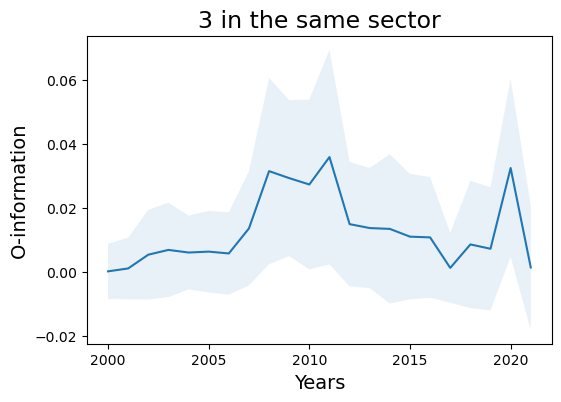

In [34]:
same_all = False

plt.figure(figsize=(6, 4))

plt.plot(years, mean_same_all, label="Mean")

lower_bound = [mean_same_all[i] - std_dev_same_all[i] for i in range(len(years))]
upper_bound = [mean_same_all[i] + std_dev_same_all[i] for i in range(len(years))]
plt.fill_between(years, lower_bound, upper_bound, alpha=0.1)

if same_all:
    for sector in sectors:
        plt.plot(years, mean_same_sectors[sector], label=sector)
    plt.legend(fontsize="x-small")

plt.xlabel("Years", size=14)
plt.ylabel("O-information", size=14)
plt.title("3 in the same sector", size=17)

name_fig = "./results/economic_results/o_info/images/divided_years/evolution_time/3_in_same_mean.pdf"
if same_all:
    name_fig = "./results/economic_results/o_info/images/divided_years/evolution_time/3_in_same_sectors.pdf"
plt.savefig(
    name_fig,
    dpi=600,
    bbox_inches="tight",
)

plt.show()

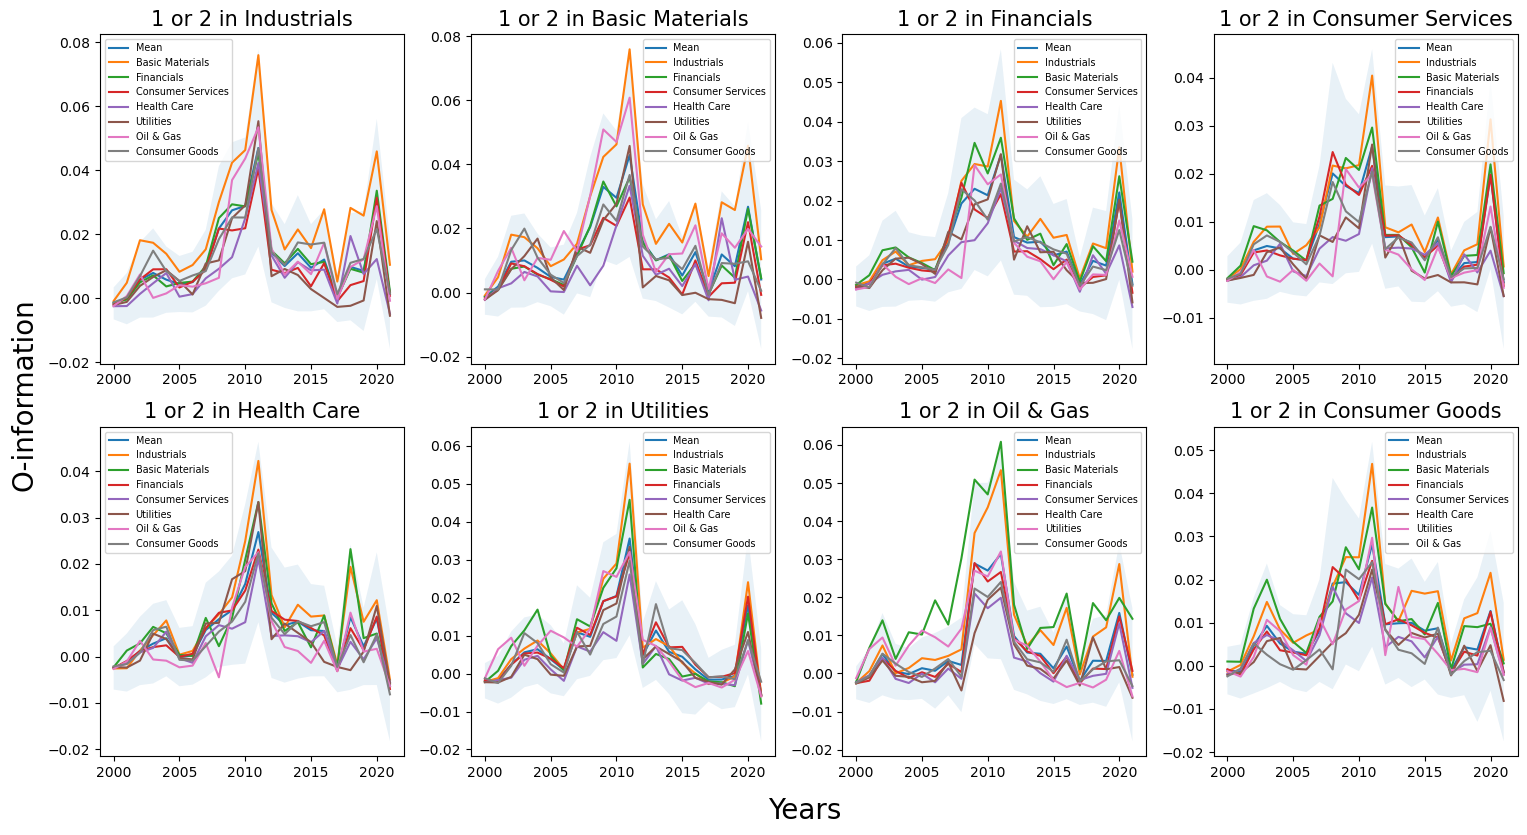

In [36]:
different_all = True

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

for index, sector in enumerate(sectors):
    row = index // 4
    col = index % 4
    ax = axs[row, col]

    mean = mean_different_all[sector]
    std_dev = std_dev_different_all[sector]

    ax.plot(years, mean, label="Mean")

    lower_bound = [mean[i] - std_dev[i] for i in range(len(years))]
    upper_bound = [mean[i] + std_dev[i] for i in range(len(years))]
    ax.fill_between(years, lower_bound, upper_bound, alpha=0.1)

    if different_all:
        other_sectors = [sect for sect in sectors if sect != sector]
        for sec in other_sectors:
            mean_sec = mean_different_sectors[sector][sec]
            ax.plot(years, mean_sec, label=sec)
        ax.legend(fontsize="x-small")

    ax.set_xticks([year for year in range(2000, 2022, 5)])

    ax.set_title(f"1 or 2 in {sector}", size=15)

fig.text(0.515, -0.02, "Years", ha="center", va="center", fontsize=20)
fig.text(-0.015, 0.5, "O-information", rotation="vertical", va="center", fontsize=20)

plt.tight_layout()

name_fig = "./results/economic_results/o_info/images/divided_years/evolution_time/1_or_2_mean.pdf"
if different_all:
    name_fig = "./results/economic_results/o_info/images/divided_years/evolution_time/1_or_2_sectors.pdf"
plt.savefig(
    name_fig,
    dpi=600,
    bbox_inches="tight",
)

plt.show()